In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import string

In [2]:
def read_nc_var(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    time = file2read.variables["time"]
    return var1, time
def read_nc_var_notime(path,file_name,var_name):
    file2read = nc.Dataset(path+file_name,'r')
    var1 = file2read.variables[var_name]
    return var1

def runmean(array, winlen):
    """Calculates a running mean of any timeseries using a window
    length (winlen).
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    return np.convolve(array, np.ones((winlen)) / winlen, mode='same')


def extrapolated_runmean(array, winlen):
    """Extrapolates a running mean at the beginning and end of the 
    time series. At the beginning, the window size is simply reduced. 
    At the end, which is critical for the t_anth estimation at the 
    stocktake, the running mean is linearly extrapolated. This is 
    done by calculating the slope over the last 31 (generally winlen) 
    years and adding a linear spline with this slope to the last 
    valid running mean value 17 (generally int(winlen / 2) +1) years 
    before stocktake to obtain the estimates for the last 15 
    (generally int(winlen / 2)) years before stocktake.
    Args:
        array: timeseries over which the running mean is calculated
        winlen: window length of running mean
    """
    winlen=15
    array_runmean = runmean(array, winlen)

    # Reduce window size down to int(winlen / 2) + 1
    # for the first int(winlen / 2) elements.
    array_runmean[:int(winlen / 2)] = np.array([
        np.mean(array[:int(winlen / 2) + i + 1])
        for i in range(int(winlen / 2))
    ])

    # Replace the last int(winlen / 2) elements by a linear extrapolation.
    array_runmean[-int(winlen / 2):] =\
        array_runmean[-int(winlen / 2) - 1]\
        + np.polyfit(np.arange(winlen), array[-winlen:], deg=1)[0]\
        * np.arange(1, int(winlen / 2) + 1)

    return array_runmean

def extrapolate_until_2000(array,startyear,years):
    winlen=15
    
    length_ts_1905_2020 = 2023-startyear 
    
    array_extrapolated = np.zeros(length_ts_1905_2020)
    array_extrapolated[0:len(years)] = array[0:len(years)]
    
    years_missing=2023-(startyear+len(years))
    array_extrapolated[-years_missing:]=array[-1]\
    + np.polyfit(np.arange(years_missing), array[-years_missing:], deg=1)[0]\
    * np.arange(1, years_missing + 1 )
    return array_extrapolated

def extrapolate_until_2020_drivers(array,var,var_drivers,trend_drivers):
    extented_array=np.empty(13)
    co2_anomaly_1995_2020=[2.46,4.21,6.42,9.1,10.77,13.37,16.77,19.12,21.08,24.01,26.57,28.77,30.89]
    rivn_anomaly_1995_2020=np.arange(1,14)
    print(rivn_anomaly_1995_2020[:])
    if var_drivers[var]=="CO2": 
        extended_array = np.mean(array[-1::]) + np.array(trend_drivers[var]) * np.array(co2_anomaly_1995_2020[:])
    if var_drivers[var]=="RIVN":
        extended_array = np.mean(array[-1::]) + np.array(trend_drivers[var]) * np.array(rivn_anomaly_1995_2020[:])
    print(rivn_anomaly_1995_2020[:])
    array_extrapolated=np.append(array,extended_array)
    return array_extrapolated

def intermediate_point(start_point,end_point,uncertainty,slope_sign):
    point = start_point + (end_point-uncertainty) * slope_sign * start_point/(end_point+uncertainty)
    return point

In [3]:
var_drivers={"SST":"CO2","hi":"CO2","NPP":"RIVN","O2":"CO2"}
trend_drivers={"SST":0.008776,"hi":0.01922*1E-9,"NPP":0.08187,"O2":-0.000494}
trend_drivers_hamocc={"SST":0.008776,"hi":0.01922*1E-9,"NPP":0.24187,"O2":-0.000494}
trend_drivers_icon={"SST":0.008776,"hi":0.01922*1E-9,"NPP":0.34187,"O2":-0.000494}

trend sst ESA CCI= 0.7281512205999423
1975-1985 average SST ESA CCI =  14.253974002525922
trend sst NOAA= 0.5914092022251368
1975-1985 average SST NOAA =  16.93869107169663
[1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022]
trend sst hadisst= 0.6587049371344424
1975-1985 average SST HadISST =  14.792139300188243
trend sst cobe= 0.5904905166669082
1975-1980 average SST COBE =  13.671839280264102


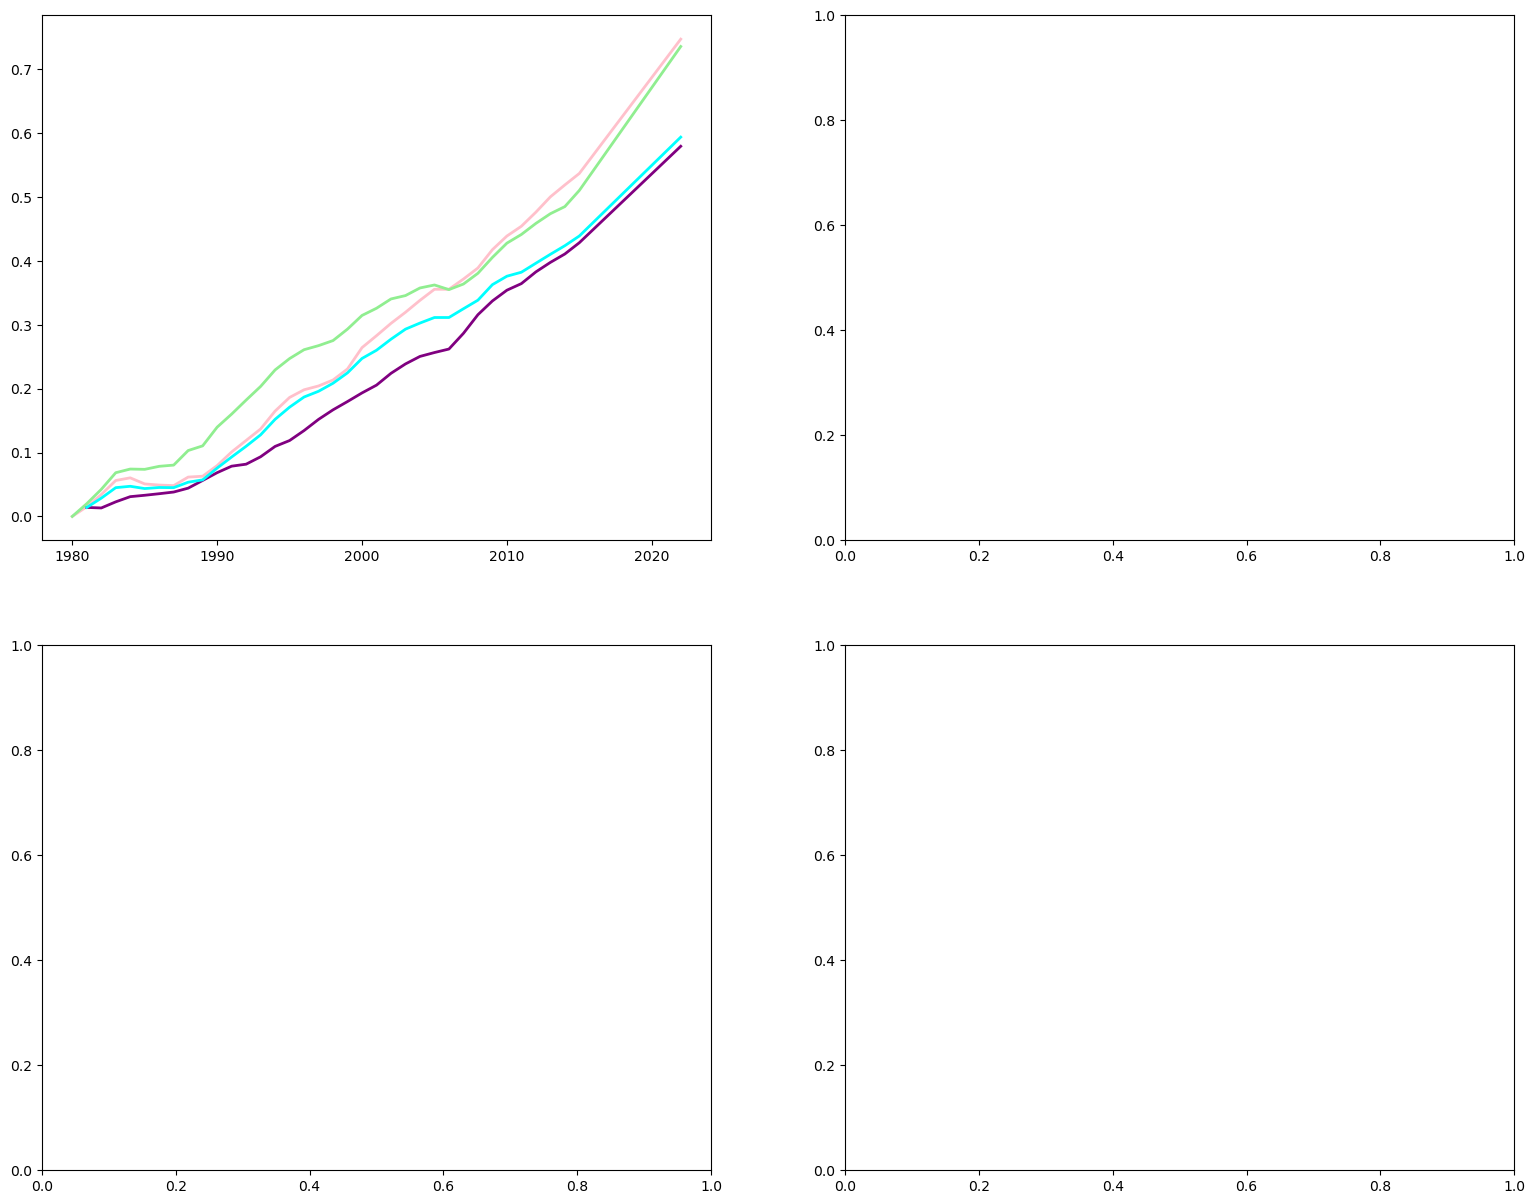

In [4]:
cwd=''

fig, ax =  plt.subplots(2,2,figsize=(19,15))
tos_shelves = []
table_names = []
var_runmean = []
runmean_len=10
shelves = ["shelf_400_TP04.nc","shelf400m_icon_cl"] #,"openocean_400_TP04.nc"]
linestyle = ["-","dashed"]
colors=["lightskyblue","darkkhaki","darkred"]
count=0

# plot observations
# observation sst
# ESACCI starts at 1980, ends at 2024
file_name = "analysis/observations/ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR3.0-v02.0-fv01.0_mean_remap_1980-2022_shelf_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"analysed_sst")
var_np = np.squeeze(np.array(var[0:-2]))
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1980,1980+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst ESA CCI=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_ESACCI = np.zeros(118)
var_sst_ESACCI[-len(var_runmean)::] = var_runmean-np.mean(np.squeeze(var_runmean[0:1]))
ax[0,0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:1]))),color="pink",linewidth=2)
print("1975-1985 average SST ESA CCI = ",np.mean(var_np[0:10])-6*var_runmean_trend-273.15)

# NOAA starts at 1981, ends at 2024
file_name = "analysis/observations/sst.an.mean_400coastalocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[0:-2]))
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1981,1981+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst NOAA=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_NOAA = np.zeros(118)
var_sst_NOAA[-len(var_runmean)::] = var_runmean+var_runmean_trend-np.mean(np.squeeze(var_runmean[0]))
ax[0,0].plot(years,(np.squeeze(var_runmean)+var_runmean_trend-np.mean(np.squeeze(var_runmean[0]))),color="purple",linewidth=2)
print("1975-1985 average SST NOAA = ",np.mean(var_np[0:10])-6*var_runmean_trend)


#plot observations
#observation sst
### starts 1870, ends 2022
file_name = "analysis/observations/HadISST_sst_annual_0p25res_400mcoastal_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[110::]))
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1980,1980+len(var_runmean))
print(years)
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst hadisst=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_hadisst = np.zeros(118)
var_sst_hadisst[-len(var_runmean):] = var_runmean-np.mean(np.squeeze(var_runmean[0:1]))
ax[0,0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:1]))),color="lightgreen",linewidth=2)
print("1975-1985 average SST HadISST = ",np.mean(var_np[0:10])-6*var_runmean_trend)

#plot observations
#observation sst
### starts 1891, ends 2023
file_name = "analysis/observations/cobe_sst.an.mean_0p25_400coastalTS.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[90:-1]))
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1981,1981+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst cobe=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_cobe = np.zeros(118)
var_sst_cobe[-len(var_runmean):] = var_runmean[0::]+var_runmean_trend-np.mean(np.squeeze(var_runmean[0]))
ax[0,0].plot(years[0::],np.squeeze(var_runmean[0::])+var_runmean_trend-np.mean(np.squeeze(var_runmean[0])),color="cyan",linewidth=2)
print("1975-1980 average SST COBE = ",np.mean(var_np[0:10])-6*var_runmean_trend)

shelf_400_TP04.nc
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
1975-1980 average SST HAMOCC =  12.562282530466716
shelf400m_icon_cl
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
1975-1980 average SST ICON =  12.88782679239909


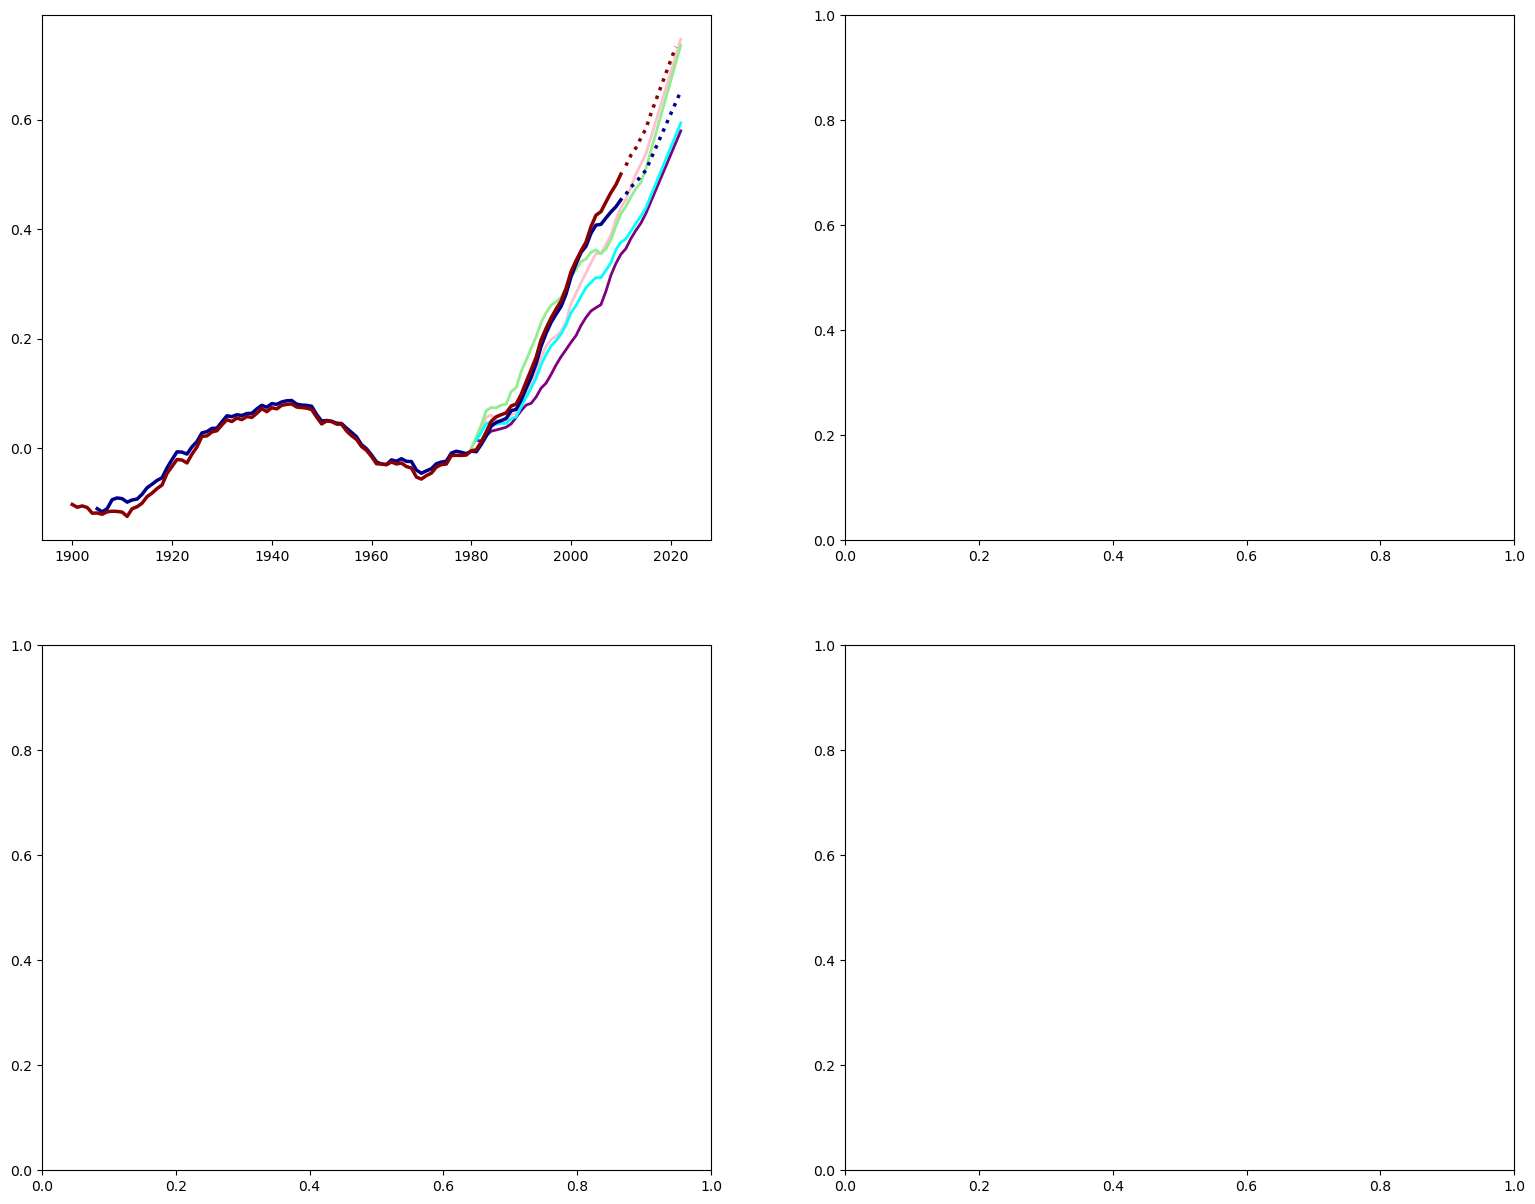

In [5]:
####TEMPORARY CELL DELETE LATER
count=0
for shelf in shelves:
    print(shelf)
    #model sst
    if shelf == "shelf_400_TP04.nc":
        file_name = "analysis/T_spatial/" + shelf + "_T_riv_sum"+".nc"
        var,time = read_nc_var(cwd,file_name,"depto")
        var_extend=extrapolate_until_2020_drivers(np.squeeze(var[:]),"SST",var_drivers,trend_drivers) 
        var_plot=extrapolated_runmean(np.squeeze(var_extend[:]),runmean_len)           
        years_plot=np.arange(1905,1905+len(var_plot))
        ax[0,0].plot(years_plot[0:106],var_plot[0:106]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=2.5)
        ax[0,0].plot(years_plot[106::],var_plot[106::]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=2.5,linestyle="dotted")
        var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
        print("1975-1980 average SST HAMOCC = ",np.mean(var_plot[70:80]))
        trend,a = np.polyfit(np.arange(0,len(time[75::])),np.squeeze(var[75::]),1)
    else:
        file_name = "analysis/T/" + shelf + "_T"+".nc"
        var,time = read_nc_var(cwd,file_name,"to")
        var_extend=extrapolate_until_2020_drivers(np.squeeze(var[:]),"SST",var_drivers,trend_drivers) 
        var_plot_icon=extrapolated_runmean(np.squeeze(var_extend[:]),runmean_len)
        years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
        ax[0,0].plot(years_plot_icon[0:111],var_plot_icon[0:111]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkred",linewidth=2.5)
        ax[0,0].plot(years_plot_icon[111:-2],var_plot_icon[111:-2]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkred",linewidth=2.5,linestyle="dotted")
        var_runmean_trend,a = np.polyfit(years_plot_icon[80:-2], var_plot_icon[80:-2], 1)
        print("1975-1980 average SST ICON = ",np.mean(var_plot_icon[75:85]))
    count=count+1
        
fig

trend sst coastal ocean HAMOCC= 0.6821244676306623
trend sst model coastal HAMOCC 1900-1980= 0.10840471302971073
trend sst coastal ocean ICON= 0.7796049699571068
trend sst model coastal ICON 1900-1980= 0.06804716182522876
118
118
118
118
sst trend coastal 0.6694469315175012
trend sst openocean ESACCI= 0.47037604495285346
1975-1985 average open ocean SST ESA CCI =  18.28481758230589
trend sst open ocean NOAA= 0.5628983182997855
1975-1980 average open ocean SST NOAA =  16.94276405511454
trend sst open ocean hadISST= 0.3149223581681088
1975-1980 average open ocean SST HadISST=  17.464149198990075
trend sst cobe= 0.5904905166669053
1975-1980 average SST COBE =  12.671839280264102
1975-1985 average SST HAMOCC =  17.97385280609131
1975-1985 average SST ICON =  17.90944717407227
trend sst model open ocean= 0.035724759958245096
trend sst model open ocean 1900-1980= 0.3009449889615721
lengths open ocean 118 118
trend sst open ocean HAMOCC= 0.3664642647507428
trend sst open ocean ICON= 0.3650992

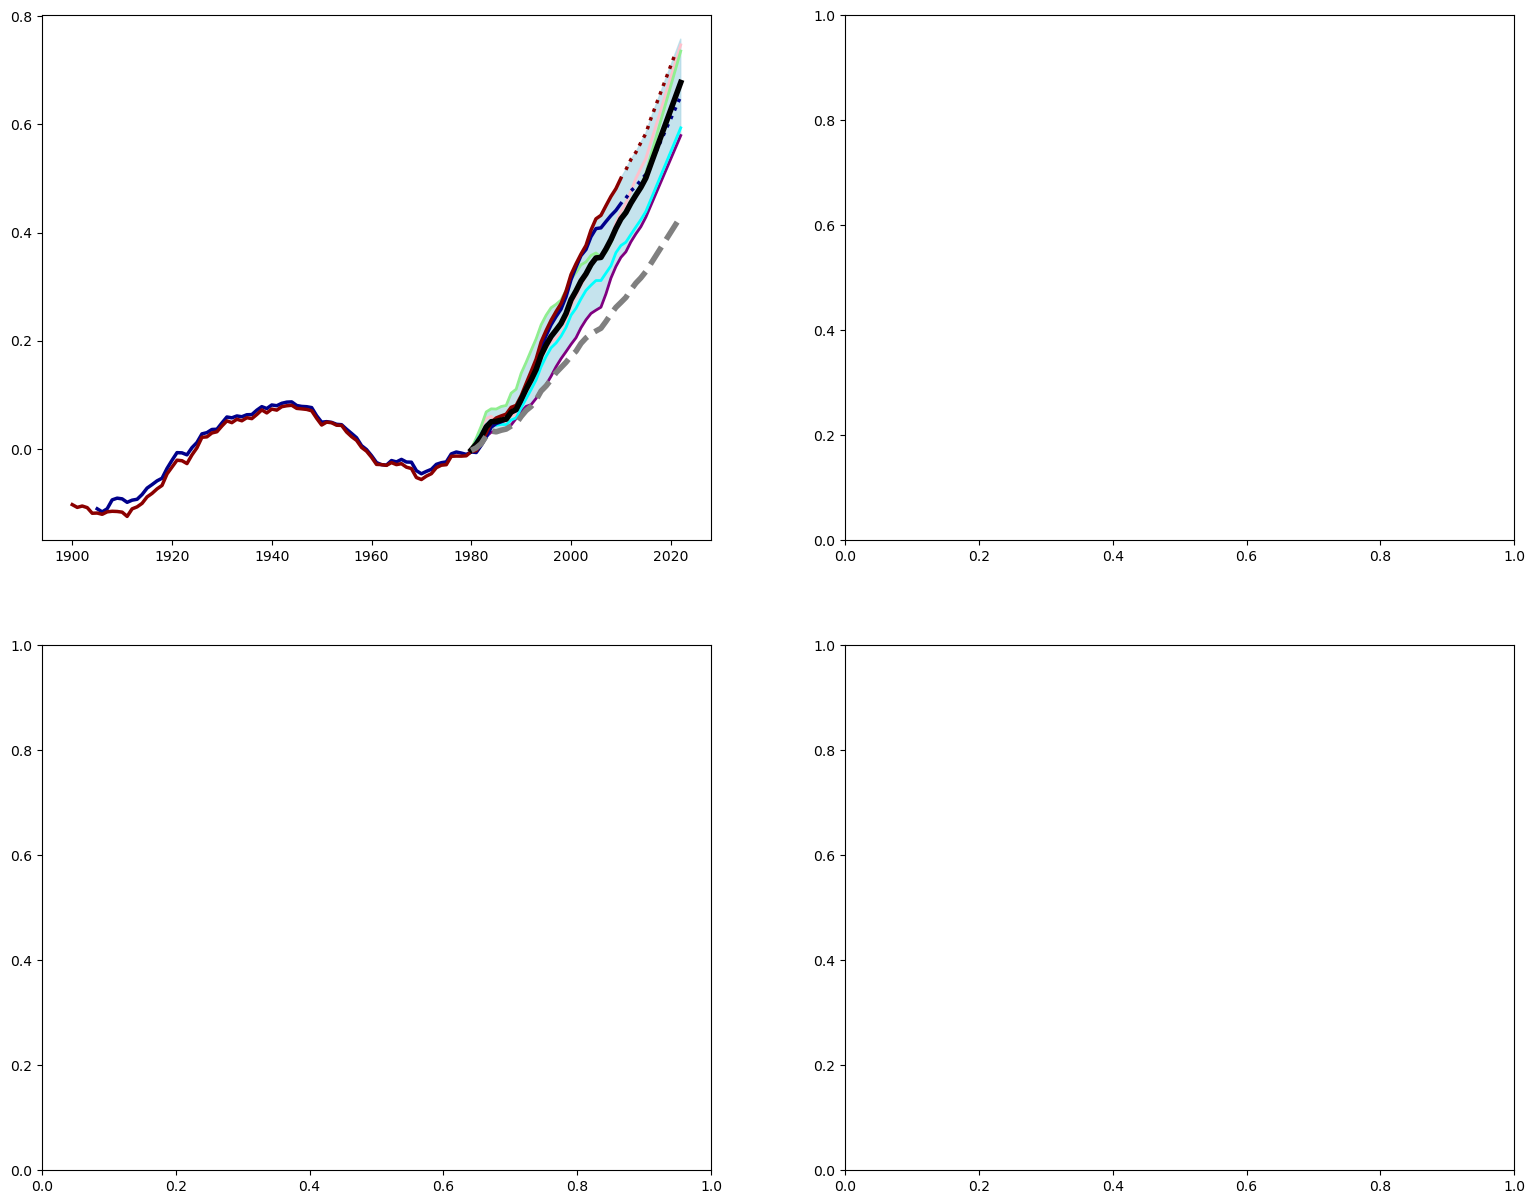

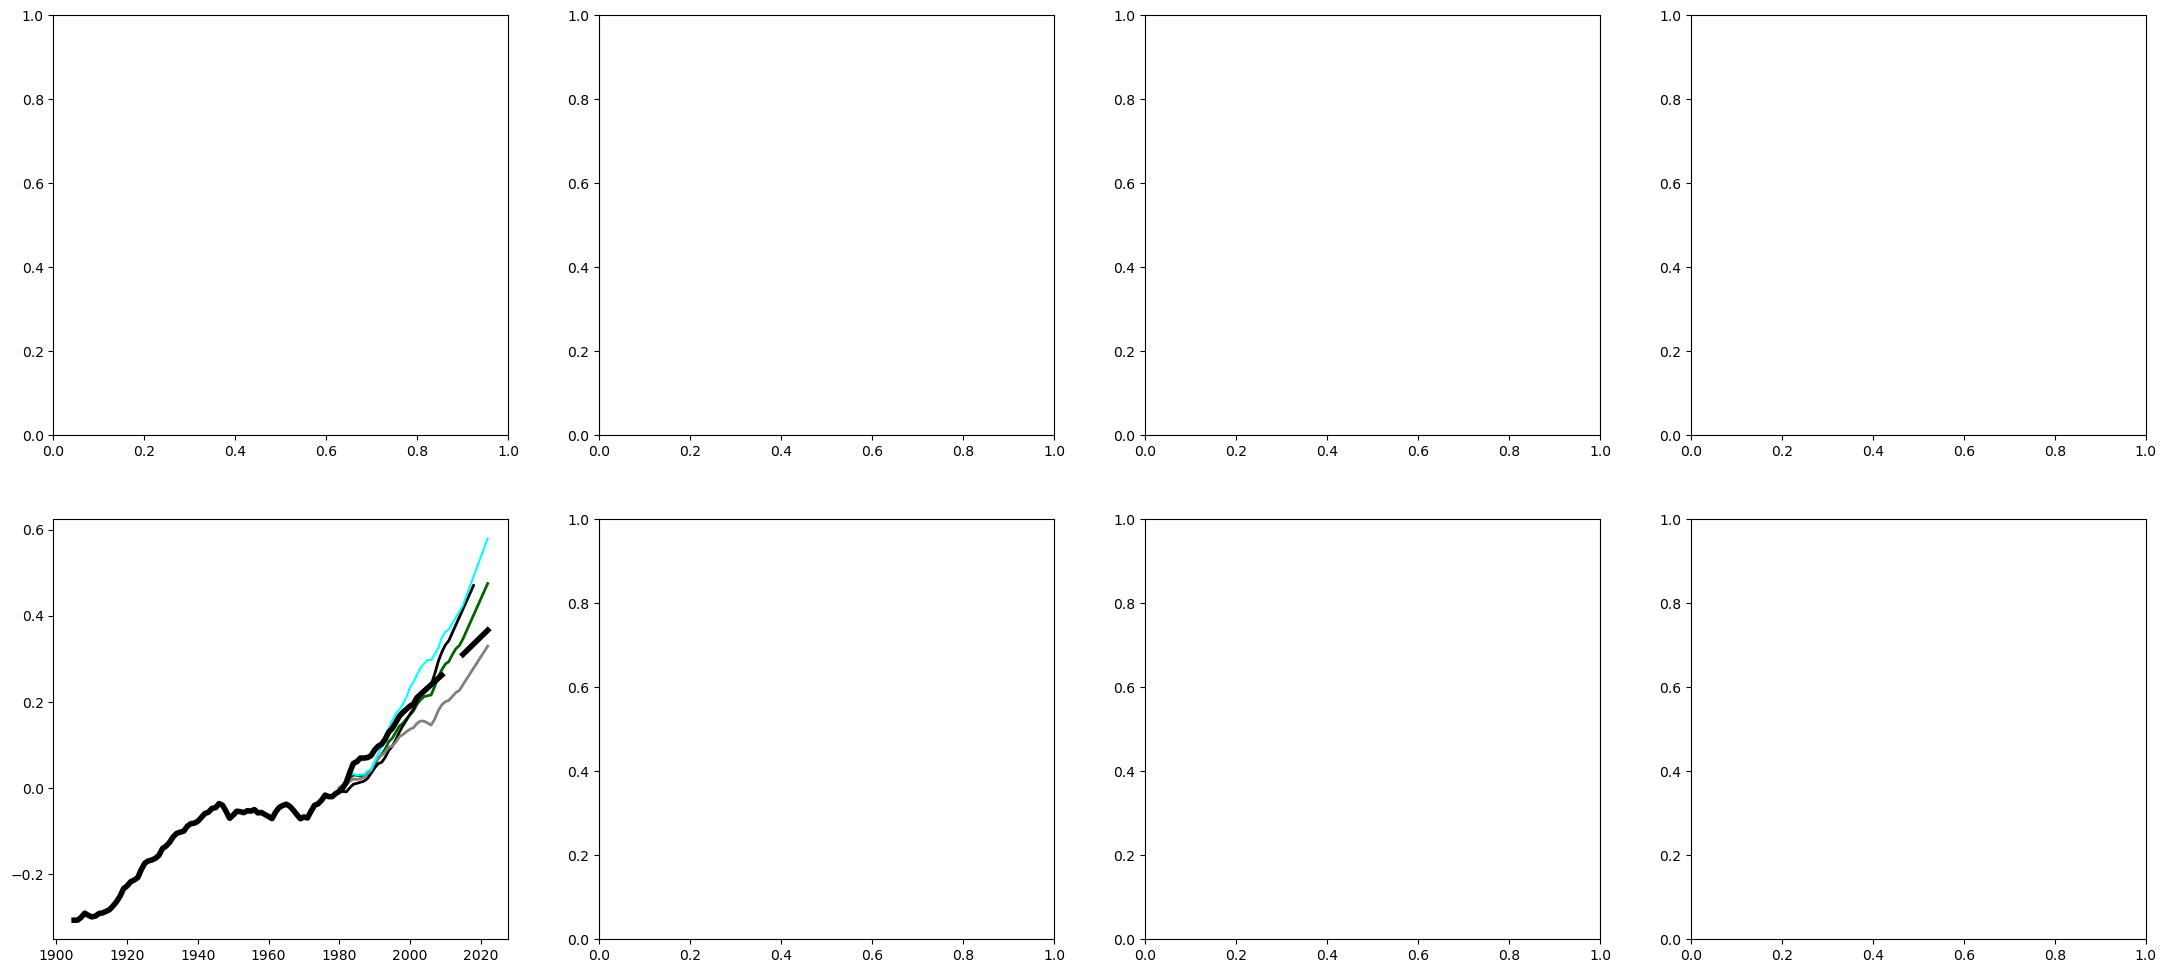

In [6]:
var_sst_hamocc = np.zeros(2023-1905)
var_sst_hamocc[-len(var_plot):] = (var_plot[0::]-np.mean(np.squeeze(var_plot[70:80])))
var_runmean_trend,a = np.polyfit(years_plot[75::], var_sst_hamocc[75::], 1)
print("trend sst coastal ocean HAMOCC=",var_runmean_trend*(len(np.arange(1980,2022))))
trend,a = np.polyfit(np.arange(0,len(time[0:75])),np.squeeze(var[0:75]),1)
print("trend sst model coastal HAMOCC 1900-1980=",trend*len(var[0:75]))

var_sst_icon = np.zeros(2023-1905)
var_sst_icon[-len(var_plot_icon):] = (var_plot_icon[5:-1]-np.mean(np.squeeze(var_plot_icon[75:85])))
var_runmean_trend,a = np.polyfit(years_plot[75::], var_sst_icon[75::], 1)
print("trend sst coastal ocean ICON=",var_runmean_trend*(len(np.arange(1980,2022))))
trend,a = np.polyfit(np.arange(0,len(time[0:80])),np.squeeze(var_sst_icon[0:80]),1)
print("trend sst model coastal ICON 1900-1980=",trend*len(var[0:80]))

print(len(var_sst_hamocc))
print(len(var_sst_icon))
print(len(var_sst_NOAA))
print(len(var_sst_hadisst))
var_sst_minimum = np.minimum(var_sst_icon,np.minimum(var_sst_cobe,
                             np.minimum(var_sst_NOAA,var_sst_hadisst)))
var_sst_minimum[var_sst_minimum==0]=np.nan
var_sst_maximum = np.maximum(var_sst_icon,(np.maximum(var_sst_cobe,
                             np.maximum(var_sst_NOAA,np.maximum(var_sst_hadisst,var_sst_hamocc)))))
var_sst_maximum[var_sst_maximum==0]=np.nan

var_concat = [var_sst_ESACCI,var_sst_NOAA,var_sst_cobe,var_sst_hadisst,var_sst_hamocc,var_sst_icon]
var_sst_mean=np.mean(var_concat,axis=0)
print("sst trend coastal",np.polyfit(years_plot[75::],var_sst_mean[75::],1)[0]*(len(np.arange(1980,2022))))
sst_trend={"coastal":np.polyfit(years_plot[75::],var_sst_mean[75::],1)[0]*(len(np.arange(1980,2022)))}

var_obs_concat = [var_sst_NOAA,var_sst_hadisst,var_sst_cobe]
var_sst_obs_mean=np.mean(var_obs_concat,axis=0)
ax[0,0].plot(years_plot[75::],var_sst_mean[75::],color="black",linewidth=4)

ax[0,0].fill_between(years_plot[0::], var_sst_minimum, var_sst_maximum, color="lightblue",alpha=0.7)
    
fig.savefig("figures/Global_coastal_TS_rel1980s.png",dpi=500)
    
    
fig2, ax2 =  plt.subplots(2,4,figsize=(27,12))    
####### open ocean #######    
#plot observations
#observation sst

## ESACCI starts at 1980, ends at 2024
file_name = "analysis/observations/ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_CDR3.0-v02.0-fv01.0_mean_remap_1980-2022_openocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"analysed_sst")
var_np = np.squeeze(np.array(var[0:-2]))
var_runmean = extrapolated_runmean(var_np,10)
years = np.arange(1980,1980+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst openocean ESACCI=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_ESACCI = np.zeros(118)
var_sst_ESACCI[-len(var_runmean)::] = var_runmean-np.mean(np.squeeze(var_runmean[0]))
ax2[1,0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0]))),color="darkgreen",linewidth=2)
print("1975-1985 average open ocean SST ESA CCI = ",np.mean(var_np[0:10])-6*var_runmean_trend-273.15)

##NOAA 1981-2024
file_name = "analysis/observations/sst.an.mean_400openocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[0:38]))
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1981,1981+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst open ocean NOAA=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_NOAA = np.zeros(118)
var_sst_NOAA[-len(var_runmean):] = var_runmean+var_runmean_trend-np.mean(np.squeeze(var_runmean[1:10]))
ax2[1,0].plot(years,(np.squeeze(var_runmean)+var_runmean_trend-np.mean(np.squeeze(var_runmean[0:10]))),color="black",linewidth=2)
print("1975-1980 average open ocean SST NOAA = ",np.mean(var_np[0:10])-6*var_runmean_trend)

#plot observations
#observation sst
file_name = "analysis/observations/HadISST_sst_annual_0p25res_400mopenocean_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[110::]))
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1980,1980+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst open ocean hadISST=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_hadisst = np.zeros(118)
var_sst_hadisst[-len(var_runmean):] = var_runmean-np.mean(np.squeeze(var_runmean[0]))
ax2[1,0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0]))),color="grey",linewidth=2)
print("1975-1980 average open ocean SST HadISST= ",np.mean(var_np[0:10])-6*var_runmean_trend)

#plot observations
#observation sst
### starts 1891, ends 2023
file_name = "analysis/observations/cobe_sst.an.mean_0p25_400openoceanTS.nc"
var,time = read_nc_var(cwd,file_name,"sst")
var_np = np.squeeze(np.array(var[90:-1]))
var_runmean = extrapolated_runmean(var_np,10)
years = np.arange(1981,1981+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
print("trend sst cobe=",var_runmean_trend*(len(np.arange(1980,2022))))
var_sst_cobe = np.zeros(118)
var_sst_cobe[-len(var_runmean):] = var_runmean[0::]-np.mean(np.squeeze(var_runmean[0]))
ax2[1,0].plot(years[0::],np.squeeze(var_runmean[0::])-np.mean(np.squeeze(var_runmean[0])),color="cyan",linewidth=1.5)
print("1975-1980 average SST COBE = ",np.mean(var_np[0:10])-6*var_runmean_trend)

shelves = ["openocean_400_TP04.nc","openocean400m_icon_cl"]
count=0
for shelf in shelves:
    if shelf == "openocean_400_TP04.nc":
        #model sst
        file_name = "analysis/T_spatial/" + shelf + "_T"+"_riv_sum.nc"
        var,time = read_nc_var(cwd,file_name,"depto")
        var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years=np.arange(1905,1905+len(var_plot))
        var_plot=extrapolate_until_2000(var_plot,1905,years)
        years_plot=np.arange(1905,1905+len(var_plot))
        ax2[1,0].plot(years_plot[0:105],var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])),color="black",linewidth=4,linestyle=linestyle[count])
        ax2[1,0].plot(years_plot[110::],var_plot[110::]-np.mean(np.squeeze(var_plot[70:80])),color="black",linewidth=4,linestyle=linestyle[count])
        print("1975-1985 average SST HAMOCC = ",np.mean(var_plot[70:80]))
        table_names = np.append(table_names,"{}".format(shelf))
        count=count+1
    else:
        file_name = "analysis/T/" + shelf + "_T"+".nc"
        var,time = read_nc_var(cwd,file_name,"to")
        var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
        years=np.arange(1900,1900+len(var_plot_icon))
        var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years)
        years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
        #ax[0,0].plot(years_plot_icon,var_plot_icon-np.mean(np.squeeze(var_plot_icon[75:85])),color="black",linewidth=2.5)
        print("1975-1985 average SST ICON = ",np.mean(var_plot_icon[75:85]))
    count=count+1

    
#### Trends open ocean
print("trend sst model open ocean=",trend*42)
trend,a = np.polyfit(np.arange(0,len(time[0:75])),np.squeeze(var[0:75]),1)
print("trend sst model open ocean 1900-1980=",trend*len(var[0:75]))
var_sst_hamocc = np.zeros(2023-1905)
var_sst_hamocc[-len(var_plot):] = (var_plot-np.mean(np.squeeze(var_plot[70:80])))
print("lengths open ocean",len(years_plot),len(var_sst_hamocc))
var_runmean_trend,a = np.polyfit(years_plot[75::], var_sst_hamocc[75::], 1)
print("trend sst open ocean HAMOCC=",var_runmean_trend*(len(np.arange(1980,2022))))

var_sst_icon = np.zeros(2023-1905)
var_sst_icon[-len(var_plot_icon):] = (var_plot_icon[5::]-np.mean(np.squeeze(var_plot_icon[75:85])))
var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_sst_icon[75:-2], 1)
print("trend sst open ocean ICON=",var_runmean_trend*(len(np.arange(1980,2022))))

#### Trends Coastal
print(len(var_sst_NOAA))
print(len(var_sst_hadisst))
var_concat = [var_sst_ESACCI,var_sst_NOAA,var_sst_hadisst,var_sst_hamocc,var_sst_icon,var_sst_cobe]
var_sst_mean=np.mean(var_concat,axis=0)
print(years_plot[75::])
ax[0,0].plot(years_plot[75::],var_sst_mean[75::],color="grey",linewidth=4,linestyle="dashed")

var_sst_minimum = np.minimum(var_sst_icon,np.minimum(var_sst_ESACCI,np.minimum(var_sst_cobe,
                             np.minimum(var_sst_NOAA,var_sst_hadisst))))
var_sst_minimum[var_sst_minimum==0]=np.nan
var_sst_maximum = np.maximum(var_sst_icon,np.maximum(var_sst_ESACCI,(np.maximum(var_sst_cobe,
                             np.maximum(var_sst_NOAA,np.maximum(var_sst_hadisst,var_sst_hamocc))))))
var_sst_maximum[var_sst_maximum==0]=np.nan

print("sst trend open ocean",np.polyfit(years_plot[75::],var_sst_mean[75::],1)[0]*len(years_plot[75::]))

print("sst trend open ocean",np.polyfit(years_plot[75::],var_sst_icon[75::],1)[0]*len(years_plot[75::]))
    
fig2.savefig("figures/Global_openocean_TS_rel1980s.png",dpi=500)
fig

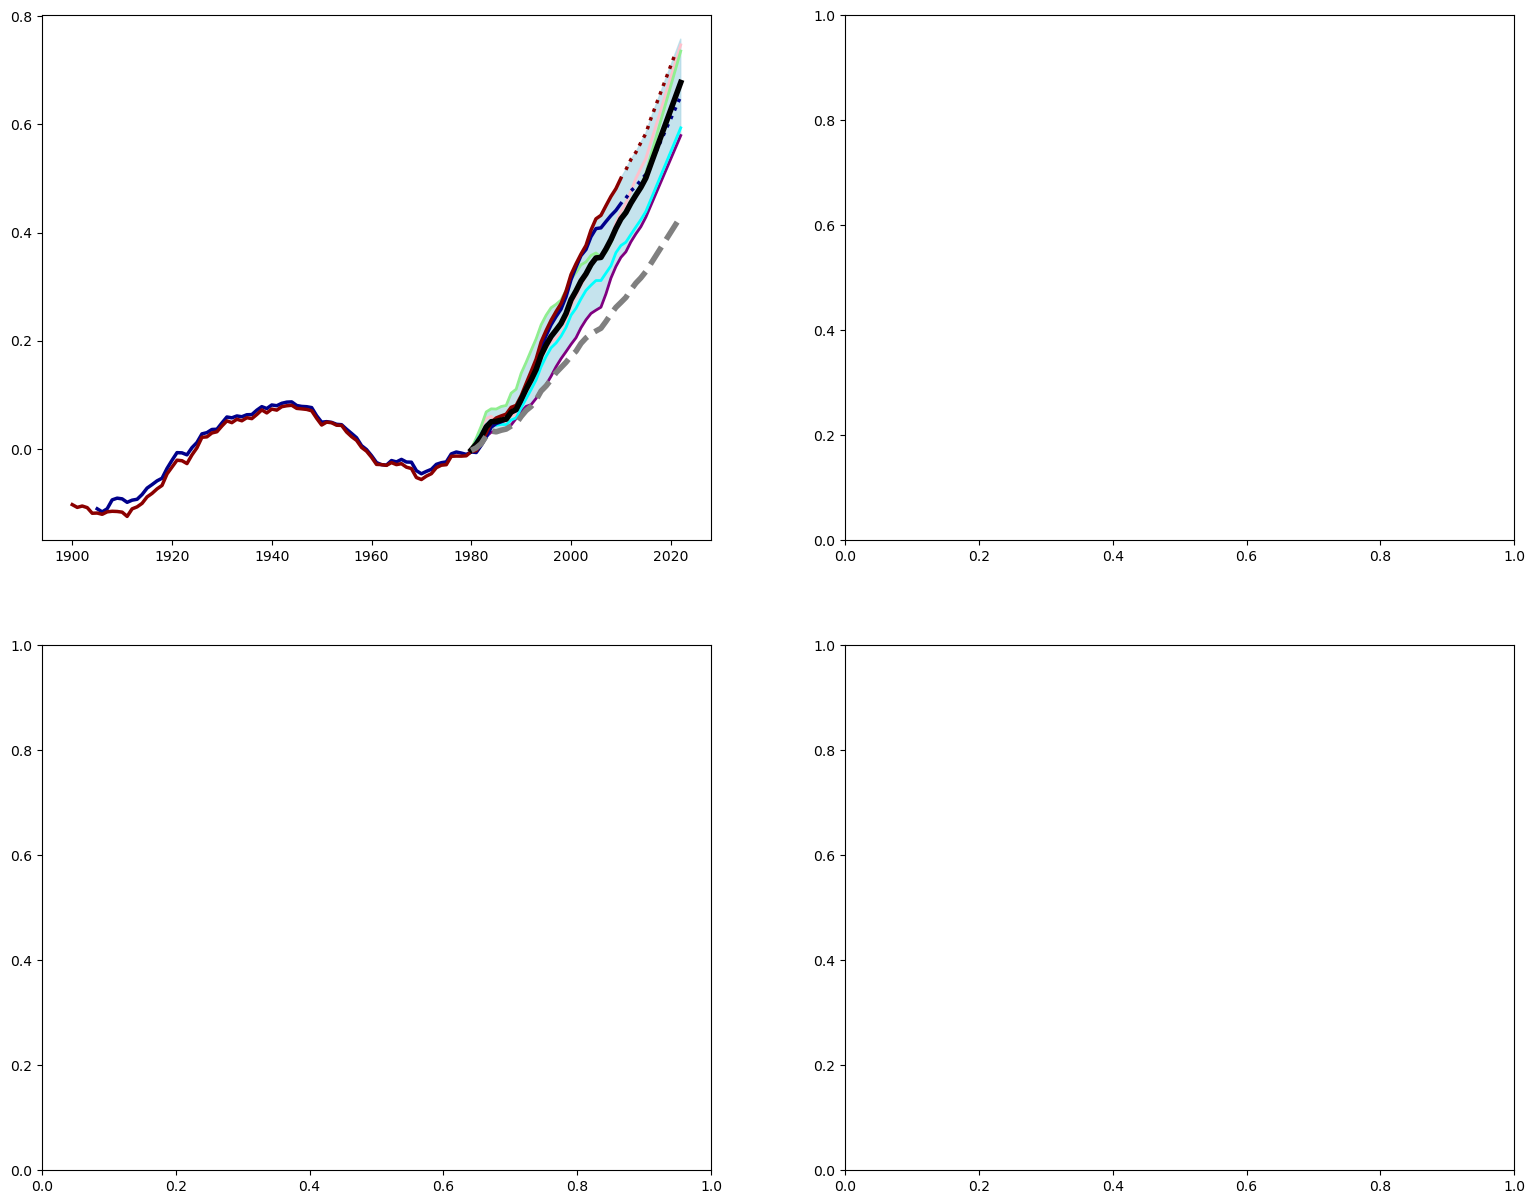

In [7]:
fig

In [8]:
# Observation hi ocean soda
## 1982-2020
file_name = "analysis/observations/hi_coastal_globalTS.nc"
var,time = read_nc_var(cwd,file_name,"htotal")
years = np.arange(1982,1982+len(var))
print("length years hi",len(var))
var_runmean_trend,a = np.polyfit(years, np.squeeze(var[:]), 1)
ts_corr=var_runmean_trend*7
ax[0,1].plot(years[0::],(np.squeeze(var[0::])-np.mean(np.squeeze(var[0:10]))+ts_corr)*1E9,color="purple",linewidth=2)
print("trend coastal SODAeth hi=",var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 coastal average H+ SODAethz = ",np.mean(var_np[0:10])-ts_corr)

var_ph_ETH = np.zeros(118)
var_ph_ETH[(-len(var[:])-2):-2] = (np.squeeze(var[:])-np.mean(np.squeeze(var[0:10]))+ts_corr)*1E9
var_ph_ETH[-2]=var_ph_ETH[-3]+var_runmean_trend*1E9 
var_ph_ETH[-1]=var_ph_ETH[-2]+var_runmean_trend*1E9 

# Observation hi lsce
## 1985-2021
file_name = "analysis/observations/dataset-ph-rep_r025-yearly_1985to2021_400shelf_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"ph")
var_np = np.squeeze(10**(-np.array(var[0:40])))
years = np.arange(1985,1985+len(var_np))
print("length years hi",len(var_np))
print(years)
var_runmean_trend,a = np.polyfit(years, var_np, 1)
ts_corr=var_runmean_trend*10
print("trend coastal lse hi=",var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 coastal average H+ CMEMS-LSCE = ",np.mean(var_np[0:10])-ts_corr)
ax[0,1].plot(years[0:40],((np.squeeze(var_np[0:40]))-np.mean(np.squeeze(var_np[0:10]))+ts_corr)*1E9,color="orange",linewidth=2) 

var_ph_lse = np.empty(118)
var_ph_lse[-len(var_np[0:40])-1:-1] = ((np.squeeze(var_np[0:40]))-np.mean(np.squeeze(var_np[0:10]))+ts_corr)*1E9 
var_ph_lse[-1]=var_ph_lse[-2]+var_runmean_trend*1E9
ax[0,1].plot(np.arange(2021,2023),(np.squeeze(var_ph_lse[-2::])),color="orange",linewidth=2,linestyle="dotted")


shelves=["shelf_250_TP04.nc","shelf400m_icon_cl"]
count = 0
for shelf in shelves:
    count=0
    if shelf=="shelf_250_TP04.nc":        
        #pH
        #for sim in ["CO2","clim","riv"]:
        for sim in ["riv"]:
            file_name = "analysis/pH/" + shelf + "_hi_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_extend=extrapolate_until_2020_drivers(np.squeeze(var[:]),"hi",var_drivers,trend_drivers) 
            var_plot=extrapolated_runmean(np.squeeze(var_extend[:]),runmean_len)           
            years_plot=np.arange(1905,1905+len(var_plot))
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            print("trend h+ HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ HAMOCC = ",np.mean(var_plot[70:80]))
            ax[0,1].plot(years_plot[0:105],(var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])))*1E9,color="darkblue",linewidth=2.5)
            ax[0,1].plot(years_plot[105::],(var_plot[105::]-np.mean(np.squeeze(var_plot[70:80])))*1E9,color="darkblue",linewidth=2.5,linestyle="dotted")
            count=count+1
        
    if shelf=="shelf400m_icon_cl":
        #for sim in ["co2_clim","all"]:
        for sim in ["all"]:
            file_name = "analysis/pH/" + shelf + "_hi_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"hi")
            var_extend=extrapolate_until_2020_drivers(np.squeeze(var[:]),"hi",var_drivers,trend_drivers) 
            var_plot_icon=extrapolated_runmean(np.squeeze(var_extend[:]),runmean_len)           
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
            var_runmean_trend,a = np.polyfit(years_plot_icon[75:-2], var_plot_icon[75:-2], 1)            
            print("trend h+ icon {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ ICON = ",np.mean(var_plot_icon[75:85]))
            ax[0,1].plot(years_plot_icon[0:110],(var_plot_icon[0:110]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9,color="darkred",linewidth=2.5)
            ax[0,1].plot(years_plot_icon[110:-1],(var_plot_icon[110:-1]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9,color="darkred",linewidth=2.5,linestyle="dotted")
            count=count+1
            
### Show fig
fig.show()


### Put together model variables for averages/mins/maxs           
var_ph_hamocc = np.zeros(118)
print(len(var_ph_hamocc))
var_ph_hamocc[-len(var_ph_hamocc)::] = (var_plot[0::]-np.mean(np.squeeze(var_plot[70:80])))*1E9
var_ph_icon = np.zeros(118)
var_ph_icon[-len(var_ph_icon)::] = (var_plot_icon[5:-1]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9

var_ph_minimum = np.minimum(var_ph_icon,np.minimum(var_ph_hamocc,var_ph_lse))
var_ph_minimum[var_ph_minimum==0]=np.nan
var_ph_maximum = np.maximum(var_ph_icon,
                            np.maximum(var_ph_hamocc,var_ph_lse,))
var_ph_maximum[var_ph_maximum==0]=np.nan

var_concat = [var_ph_lse,var_ph_hamocc,var_ph_icon]
var_ph_mean=np.mean(var_concat,axis=0)

var_concat_obs = [var_ph_lse,var_ph_ETH]
var_ph_obs_mean=np.mean(var_concat_obs,axis=0)
ax[0,1].plot(years_plot[75::],var_ph_mean[75::],color="black",linewidth=4)

print("ph trend coastal",np.polyfit(years_plot[75::],var_ph_mean[75::],1)[0]*40)
print("h+ trend coastal",-np.log10(np.polyfit(years_plot[75::],var_ph_mean[75::],1)[0]*40))
ph_trend={"coastal":np.polyfit(years_plot[75::],var_ph_mean[75::],1)[0]*len(years_plot[75::])*1E9/(0.4*1E9)}

ax[0,1].fill_between(years_plot, var_ph_minimum, var_ph_maximum, color="lightsteelblue",alpha=0.4)

        
fig.show()


file_name = "analysis/observations/hi_0p25res_400mopenocean_annual_fldmean.nc"
var,time = read_nc_var(cwd,file_name,"htotal")
var_np = np.squeeze(10**(-np.array(var[0:40])))
years = np.arange(1982,1982+len(var))
var_runmean_trend,a = np.polyfit(years, np.squeeze(var[:]), 1)
ts_corr=var_runmean_trend*7
ax2[1,1].plot(years[:],(np.squeeze(var[:])-np.mean(np.squeeze(var[0:10]))+ ts_corr)*1E9 ,color="black",linewidth=1) 
print("trend SODAeth hi open ocean=",var_runmean_trend*(len(years)))
print("1975-1985 open ocean average H+ SODAethz = ",np.mean(var_np[0:10])-ts_corr)
var_ph_lse = np.zeros(118)
var_ph_lse[-len(var_np[0:40])-1:-1] = ((np.squeeze(var_np[0:40]))-np.mean(np.squeeze(var_np[0:10]))+ts_corr)*1E9 


shelves=["openocean_400_TP04.nc","openocean400m_icon_cl"]

count = 0
for shelf in shelves:
    for sim in ["CO2","clim","riv"]:
        if shelf=="openocean_400_TP04.nc":
            #ph
            file_name = "analysis/pH/" + shelf + "_hi_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len)      
            years_plot=np.arange(1905,1905+len(var))
            var_plot=extrapolate_until_2000(var_plot,1905,years_plot)
            years_plot=np.arange(1905,1905+len(var_plot[:]))                        
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            print("trend h+ open ocean HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ HAMOCC = ",np.mean(var_plot[70:80]))
            #ax2[1,1].plot(years_plot,(var_plot-np.mean(np.squeeze(var[75:85])))*1E9,color=colors[count],linewidth=4)
            count=count+1
        
        if shelf=="openocean400m_icon_cl":
            file_name = "analysis/pH/" + shelf + "_hi_"+ "all" + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"hi")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)      
            years=np.arange(1900,1900+len(var_plot_icon))
            var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years)
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon[:]))
            var_runmean_trend,a = np.polyfit(years_plot_icon[80:-2], var_plot_icon[80:-2], 1)
            print("trend h+ open ocean icon {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 average H+ ICON = ",np.mean(var_plot_icon[75:85]))
            #ax[0,1].plot(years_plot_icon,(var_plot_icon[:]-np.mean(np.squeeze(var[75:85])))*1E9,color="black",linewidth=3.5)
            count=count+1

print("h+ trend coastal",np.polyfit(years_plot[75::],var_plot[75::],1)[0]*len(years_plot[70::]))

### Put together model variables for averages/mins/maxs           
var_ph_hamocc = np.zeros(118)
var_ph_hamocc[-len(var_plot[0:118]):] = (var_plot[:]-np.mean(np.squeeze(var_plot[70:80])))*1E9
var_ph_icon = np.zeros(118)
var_ph_icon[-len(var_plot[0:118]):] = (var_plot_icon[4:-1]-np.mean(np.squeeze(var_plot_icon[75:85])))*1E9

print(len(var_ph_lse))
print(len(var_ph_hamocc))
print(len(var_ph_icon))

var_concat_obs = [var_ph_lse,var_ph_hamocc,var_ph_icon]
var_ph_mean = np.mean(var_concat_obs,axis=0)
print(years_plot[75::])
ax[0,1].plot(years_plot[75:-1],var_ph_mean[75:-1],color="grey",linewidth=4,linestyle="dashed")



length years hi 39
trend coastal SODAeth hi= 1.339097246584073e-09
1975-1985 coastal average H+ SODAethz =  12.756195068136192
length years hi 37
[1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020 2021]
trend coastal lse hi= 1.2155156350388827e-09
1975-1985 coastal average H+ CMEMS-LSCE =  7.567723349510617e-09
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend h+ HAMOCC riv= 1.3213290639623432e-09
1975-1985 coastal average H+ HAMOCC =  9.117826831328556e-09
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend h+ icon all= 1.340979548963582e-09
1975-1985 coastal average H+ ICON =  8.00457548540597e-09
118
ph trend coastal 1.3131613416277002
h+ trend coastal -0.11831808897894766
trend SODAeth hi open ocean= 1.2043572805709172e-09
1975-1985 open ocean average H+ SODAethz =  0.99999999978

/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/3783186636.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/3783186636.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


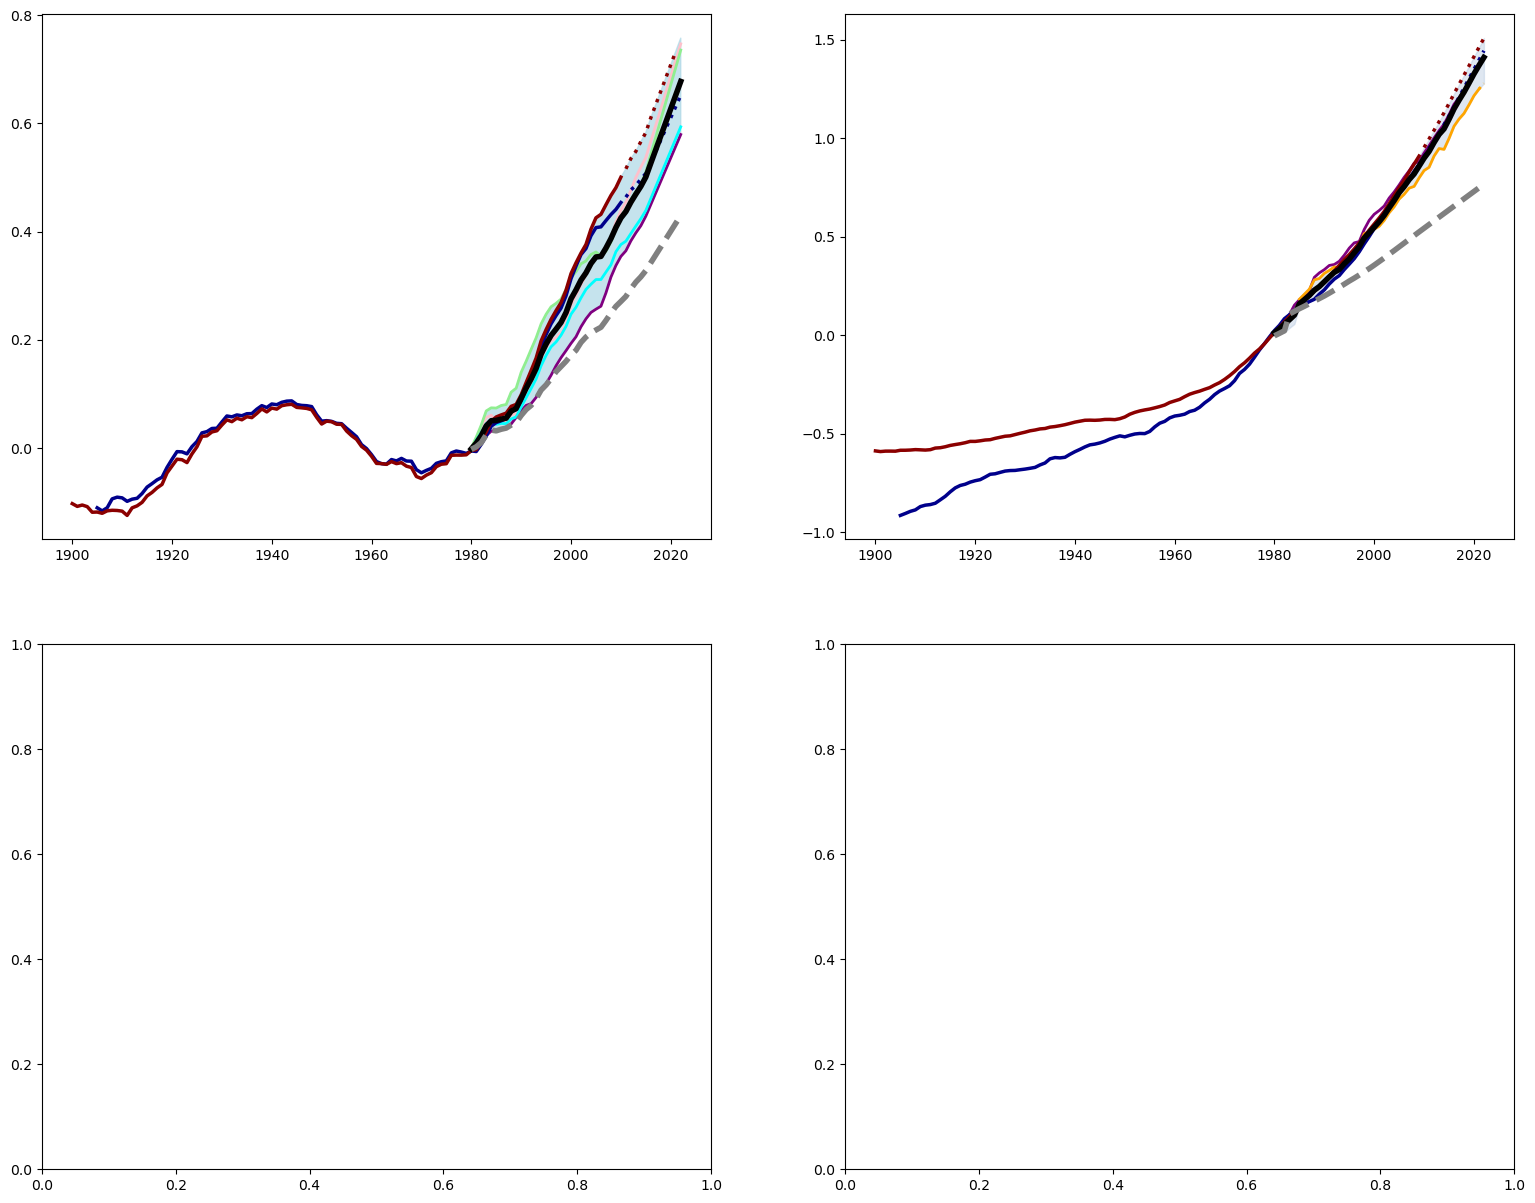

In [9]:
fig

In [10]:
#observation NPP
file_name = "analysis/observations/vgpm_wgrid_annual_all_0p5res_coastal_total.nc"
var,time = read_nc_var(cwd,file_name,"npp")
var = np.average(var[:].reshape(-1, 19), axis=0)
var = var / (36 * 1E12)
var_runmean =extrapolated_runmean(var,5)
years = np.arange(2003,2003+len(var))
var_runmean_trend,a = np.polyfit(np.arange(0,19), var_runmean, 1)
ax[1,0].plot(np.arange(1980,2022),(np.arange(0,42)*var_runmean_trend),color="green",linestyle="dashed",linewidth=3)
ax[1,0].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[1:11])))+0.40*1E15/(36 * 1E12),color="green",linewidth=3) 

print("trend NPP coastal VGPM {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 coastal average NPP VGPM = ",(np.mean(var_plot[0:5])-var_runmean_trend*22))

var_npp_vgpm = np.zeros(118)
var_npp_vgpm[-42-1:-1] = (np.arange(0,42)*var_runmean_trend)
var_npp_vgpm[-1] = var_npp_vgpm[-2] + var_runmean_trend 

colors=["darkkhaki","darkred"]

shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
count = 0
for shelf in shelves:
    count=0
    if shelf=="shelf_400_TP04.nc":        
        #NPP
        for sim in ["riv"]:
            file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_runmean=extrapolated_runmean(np.squeeze(var[:]),5) 
            var_plot=extrapolate_until_2020_drivers(np.squeeze(var_runmean[:]),"NPP",var_drivers,trend_drivers_hamocc)         
            years_plot=np.arange(1905,1905+len(var_plot))
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            ax[1,0].plot(years_plot[0:105],var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=3)
            ax[1,0].plot(years_plot[105::],var_plot[105::]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=3,linestyle="dotted")
            var_runmean_trend,a = np.polyfit(years_plot[75::], var_plot[75::], 1)
            print("trend NPP coastal HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2022))))
            print("1975-1985 coastal average NPP HAMOCC = ",np.mean(var_plot[70:80]))            
            sim_prev=sim
            count=count+1
            
    if shelf=="shelf400m_icon_cl":
        #for sim in ["co2_clim","all"]:
        for sim in ["all"]:
            file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_perm2_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"NPP")
            var_extend=extrapolate_until_2020_drivers(np.squeeze(var[:]),"NPP",var_drivers,trend_drivers_icon) 
            var_plot_icon=extrapolated_runmean(np.squeeze(var_extend[:]),5)           
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
            var_runmean_trend,a = np.polyfit(years_plot_icon[75:-2], var_plot_icon[75:-2], 1)            
            print("trend h+ icon {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 coastal average H+ ICON = ",np.mean(var_plot_icon[75:85]))
            ax[1,0].plot(years_plot_icon[0:110],(var_plot_icon[0:110]-np.mean(np.squeeze(var_plot_icon[75:85]))),color="darkred",linewidth=2.5)
            ax[1,0].plot(years_plot_icon[110:-1],(var_plot_icon[110:-1]-np.mean(np.squeeze(var_plot_icon[75:85]))),color="darkred",linewidth=2.5,linestyle="dotted")
            print("1975-1985 coastal average NPP ICON = ",np.mean(var_plot_icon[75:85]))
            
### Model NPP
var_npp_hamocc = np.zeros(118)
var_npp_hamocc[-118::] = (var_plot[:] - np.mean(var_plot[70:80]))
var_npp_icon = np.zeros(118)
var_npp_icon[-118::] = (var_plot_icon[5:-1] - np.mean(var_plot_icon[75:85]))

var_npp_minimum = np.minimum(var_npp_icon,np.minimum(var_npp_hamocc,var_npp_vgpm))
var_npp_minimum[var_npp_minimum==0]=np.nan
var_npp_maximum = np.maximum(var_npp_icon,np.maximum(var_npp_hamocc,var_npp_vgpm))
var_npp_maximum[var_npp_maximum==0]=np.nan

var_concat = [var_npp_vgpm,var_npp_hamocc,var_npp_icon]
var_npp_mean = np.mean(var_concat,axis=0)
ax[1,0].plot(years_plot[75::],var_npp_mean[75::],color="black",linewidth=4)

#print(len(years_plot[70:-2]))
#print(len(var_npp_mean[70:-2]))
print("npp trend coastal since 1980s",np.polyfit(years_plot[75::],var_npp_mean[75::],1)[0]*len(years_plot[75:-1]))
print("npp trend coastal since 1900s",np.polyfit(years_plot[0:75],var_npp_mean[0:75],1)[0]*len(years_plot[0:75]))

print(years_plot)
ax[1,0].fill_between(years_plot, var_npp_minimum, var_npp_maximum, color="lightsteelblue",alpha=0.4)        
        
#observation NPP
file_name = "analysis/observations/vgpm_wgrid_annual_all_0p25res_400mopenocean_fldsum.nc"
var,time = read_nc_var(cwd,file_name,"npp")
var = np.average(var[:].reshape(-1, 19), axis=0)
var_runmean =extrapolated_runmean(var,5)
years = np.arange(2002,2002+len(var))


shelves=["openocean_400_TP04.nc"]
count = 0
for shelf in shelves:
    for sim in ["clim","riv"]:
        #NPP
        file_name = "analysis/NPP/" + shelf + "_NPP_"+ sim + "_sum" + ".nc"
        var,time = read_nc_var(cwd,file_name,"NPP")
        print(np.shape(var))
        var_plot=extrapolated_runmean(np.squeeze(var[:]),runmean_len) 
        years=np.arange(1905,1905+len(var_plot))
        var_plot=extrapolate_until_2000(var_plot,1905,years)
        var_plot = var_plot / (650 * 1E12)
        years_plot=np.arange(1905,1905+len(var_plot))
        var_runmean_trend,a = np.polyfit(years_plot[75::], var_plot[75::], 1)
        print("trend NPP open ocean HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
        print("1975-1985 open ocean average NPP HAMOCC = ",(np.mean(var_plot[70:80])))
        sim_prev=sim
        count=count+1

### Model NPP
var_npp_hamocc = np.zeros(118)
var_npp_hamocc[-118::] = (var_plot[0:118] - np.mean(var_plot[70:80]))
ax[1,0].plot(years_plot[75::],var_npp_hamocc[75::],color="grey",linewidth=4,linestyle="dashed")

trend NPP coastal VGPM riv= 18.00550977341667
1975-1985 coastal average NPP VGPM =  -9.431457487289126
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend NPP coastal HAMOCC riv= 11.750283577001642
1975-1985 coastal average NPP HAMOCC =  124.46995630900065
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend h+ icon all= 13.349948595207922
1975-1985 coastal average H+ ICON =  162.25124186197917
1975-1985 coastal average NPP ICON =  162.25124186197917
npp trend coastal since 1980s 14.52262502016315
npp trend coastal since 1900s 12.788623663999479
[1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918
 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932
 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946
 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1

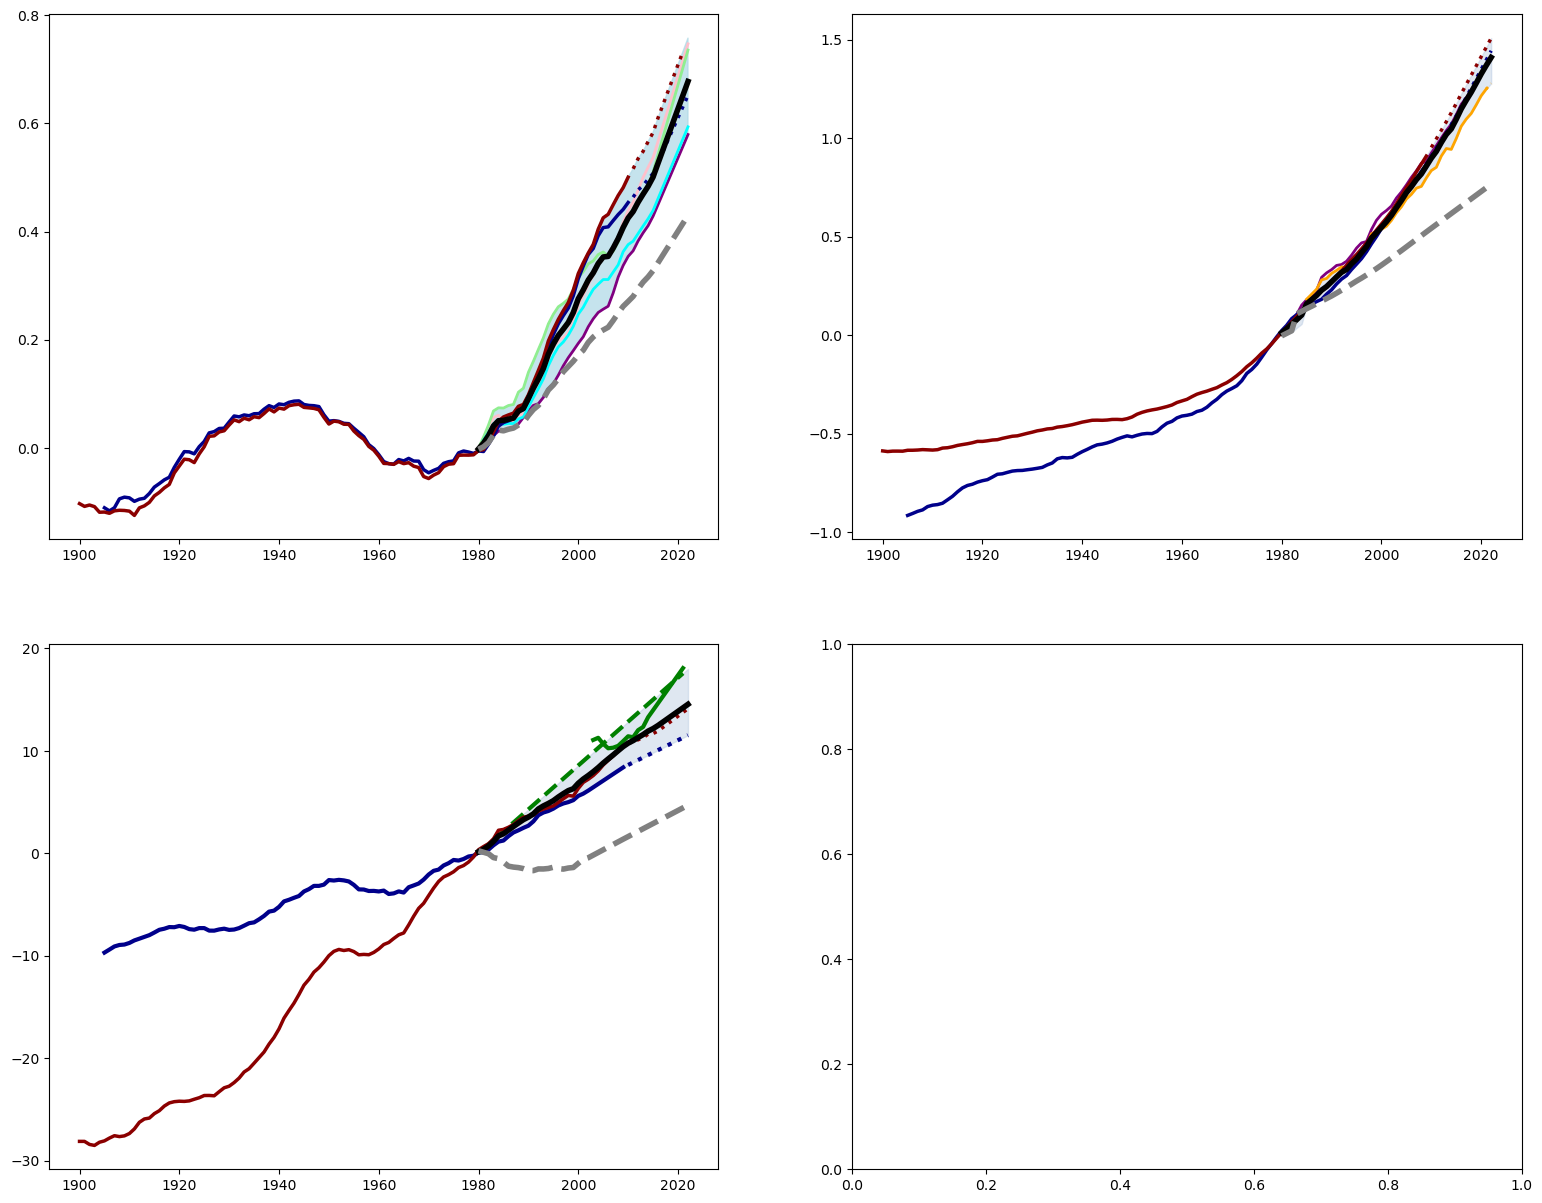

In [11]:
fig

In [12]:
#observation O2
##### Ito et al. 2019
file_name = "analysis/observations/o2_OI1x1_1967_2012_wod2018_0d25_400coastal_fldmean.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"o2")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np * 32 
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1967,1967+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
ax[1,1].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10]))),color="purple",linewidth=2)
print("trend O2 coastal ocean Ito et al. 2022=",var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 coastal average O2 Ito et al. 2022 = ",np.mean(var_np[0:10]))
var_o2_ito2022 = np.zeros(118)
var_o2_ito2022[-len(var_runmean[:])-10:-10] = (np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10])))
var_o2_ito2022[-10::]=var_o2_ito2022[-11]+var_runmean_trend*np.arange(1,11)
ax[1,1].plot(np.arange(2013,2023),(np.squeeze(var_o2_ito2022[-10::])),color="purple",linewidth=2,linestyle="dotted")

#### Ito et al., 2023
file_name = "analysis/observations/ito2023_remap0p25_shelf_fldmean_vertmean.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"o2")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np/1000*32
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1965,1965+len(var_runmean))
print(years)
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
ax[1,1].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[10:20]))),color="orange",linewidth=2)
print("trend O2 coastal ocean Ito et al. 2024=",var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 coastal average O2 Ito et al. 2024 = ",np.mean(var_np[10:20]))
var_o2_ito2024 = np.zeros(118)
var_o2_ito2024[-len(var_runmean[:])-1:-1] = (np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10])))
var_o2_ito2024[-1]=var_o2_ito2024[-2]+var_runmean_trend
ax[1,1].plot(np.arange(2021,2023),(np.squeeze(var_o2_ito2024[-2::])),color="orange",linewidth=2,linestyle="dotted")


shelves=["shelf_400_TP04.nc","shelf400m_icon_cl"]
count=0
for shelf in shelves:
    count=0
    if shelf=="shelf_400_TP04.nc":        
        #pH
        #for sim in ["clim","riv"]:
        for sim in ["riv"]:
            #Oxygen
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_runmean=extrapolated_runmean(np.squeeze(var[:]),runmean_len) 
            var_plot=extrapolate_until_2020_drivers(np.squeeze(var_runmean[:]),"O2",var_drivers,trend_drivers)         
            years_plot=np.arange(1905,1905+len(var_plot))
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            ax[1,1].plot(years_plot[0:105],var_plot[0:105]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=3)
            ax[1,1].plot(years_plot[105::],var_plot[105::]-np.mean(np.squeeze(var_plot[70:80])),color="darkblue",linewidth=3,linestyle="dotted")
            var_runmean_trend,a = np.polyfit(years_plot[75::], var_plot[75::], 1)
            print("trend O2 coastal HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2022))))
            print("1975-1985 coastal average O2 HAMOCC = ",np.mean(var_plot[70:80])*32)
            count=count+1
    if shelf=="shelf400m_icon_cl":
        #for sim in ["co2_clim","all"]:
        for sim in ["all"]:
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"o2")
            var_runmean_icon=extrapolated_runmean(np.squeeze(var[:]),runmean_len)
            var_plot_icon=extrapolate_until_2020_drivers(np.squeeze(var_runmean_icon[:]),"O2",var_drivers,trend_drivers)
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon))
            var_runmean_trend,a = np.polyfit(years_plot_icon[75:-2], var_plot_icon[75:-2], 1)
            ax[1,1].plot(years_plot_icon[0:110],var_plot_icon[0:110]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkred",linewidth=3)
            ax[1,1].plot(years_plot_icon[110:-1],var_plot_icon[110:-1]-np.mean(np.squeeze(var_plot_icon[75:85])),color="darkred",linewidth=3,linestyle="dotted")
            var_runmean_trend,a = np.polyfit(years_plot_icon[75::], var_plot_icon[75::], 1)
            print("trend O2 coastal ICON {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2022))))
            print("1975-1985 coastal average O2 ICON = ",np.mean(var_plot_icon[75:85])*32)
            count=count+1

var_o2_hamocc = np.zeros(118)
var_o2_hamocc[:] = (var_plot[:])-np.mean(np.squeeze(var_plot[70:80]))
var_o2_icon = np.zeros(118)
var_o2_icon[:] = (var_plot_icon[5:-1])-np.mean(np.squeeze(var_plot_icon[75:85]))

var_o2_minimum = np.minimum(var_o2_icon,(np.minimum(var_o2_hamocc,np.minimum(var_o2_ito2022,var_o2_ito2024))))
var_o2_minimum[var_o2_minimum==0]=np.nan
var_o2_maximum = np.maximum(var_o2_icon,(np.maximum(var_o2_hamocc,np.minimum(var_o2_ito2022,var_o2_ito2024))))
var_o2_maximum[var_o2_maximum==0]=np.nan

var_concat = [var_o2_icon,var_o2_hamocc,var_o2_ito2022,var_o2_ito2024]
var_o2_mean=np.mean(var_concat,axis=0)
print("O2 trend coastal since 1980s",np.polyfit(years_plot[75::],var_o2_mean[75::],1)[0]*len(years_plot[75::]))

### Plot observational means
var_concat = [var_o2_ito2022,var_o2_ito2024]
var_o2_obs_mean=np.mean(var_concat,axis=0)
ax[1,1].plot(years_plot[75::],var_o2_mean[75::],color="black",linewidth=4)
ax[1,1].fill_between(years_plot[75::], var_o2_minimum[75::], var_o2_maximum[75::], color="lightsteelblue",alpha=0.4)  




shelves=["openocean_400_TP04.nc","openocean400m_icon_cl"]
count=0
for shelf in shelves:
    for sim in ["clim","riv"]:
        if shelf=="openocean_400_TP04.nc":
            # Oxygen
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ sim + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"depto")
            var_plot=extrapolated_runmean(np.squeeze(var[:]-np.mean(var[70:80])),runmean_len)
            years=np.arange(1905,1905+len(var_plot))
            var_plot=extrapolate_until_2000(var_plot,1905,years)
            years_plot=np.arange(1905,1905+len(var_plot[:]))
            var_runmean_trend,a = np.polyfit(years_plot[75:-2], var_plot[75:-2], 1)
            print("trend O2 open ocean HAMOCC {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))
            print("1975-1985 open ocean average O2 HAMOCC = ",np.mean(var_plot[70:80])*32)
            count=count+1
        else:
            file_name = "analysis/oxygen/" + shelf + "_oxygen_"+ "all" + "_mean" + ".nc"
            var,time = read_nc_var(cwd,file_name,"o2")
            var_plot_icon=extrapolated_runmean(np.squeeze(var[:]-np.mean(var[75:85])),runmean_len)
            years_icon=np.arange(1900,1900+len(var_plot_icon))
            var_plot_icon=extrapolate_until_2000(var_plot_icon,1900,years_icon)
            years_plot_icon=np.arange(1900,1900+len(var_plot_icon[:]))
            var_runmean_trend,a = np.polyfit(years_plot_icon[75:-2], var_plot_icon[75:-2], 1)
            print("trend O2 open ocean ICON {}=".format(sim),var_runmean_trend*(len(np.arange(1980,2020))))            
            print("1975-1985 open ocean average O2 ICON = ",np.mean(var_plot_icon[75:85])*32)            
            count=count+1

            

            
#### Ito et al., 2023
file_name = "analysis/observations/ito2023_remap0p25_openocean_fldmean_vertmean.nc"
colors=["darkkhaki","darkred"]
var,time = read_nc_var(cwd,file_name,"o2")
var_np = np.squeeze(np.array(var[:]))
var_np=var_np/1000*32
var_runmean = extrapolated_runmean(var_np,15)
years = np.arange(1965,1965+len(var_runmean))
var_runmean_trend,a = np.polyfit(years, var_runmean, 1)
#ax[1,1].plot(years,(np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[10:20]))),color="orange",linewidth=2)
print("trend O2 open ocean Ito et al. 2024=",var_runmean_trend*(len(np.arange(1980,2022))))
print("1975-1985 open ocean average O2 Ito et al. 2024 = ",np.mean(var_np[10:20]))
var_o2_ito2024 = np.zeros(117)
var_o2_ito2024[-len(var_runmean[:])::] = (np.squeeze(var_runmean)-np.mean(np.squeeze(var_runmean[0:10])))

            
            
var_o2_hamocc = np.zeros(118)
var_o2_hamocc[:] = (var_plot[0::] - np.mean(var_plot[70:80]))
var_o2_icon = np.zeros(118)
var_o2_icon[:] = (var_plot_icon[5::] - np.mean(var_plot_icon[75:85]))

var_concat = [var_o2_icon,var_o2_hamocc]
var_o2_mean=np.mean(var_concat,axis=0)
print("O2 trend open ocean since 1980s",np.polyfit(years_plot[75::],var_o2_mean[75::],1)[0]*len(years_plot[75::]))
ax[1,1].plot(years_plot[75::],var_o2_mean[75::],color="grey",linewidth=4,linestyle="dashed")

trend O2 coastal ocean Ito et al. 2022= -0.08685150700812212
1975-1985 coastal average O2 Ito et al. 2022 =  0.008025654137587357
[1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
trend O2 coastal ocean Ito et al. 2024= -0.18500237760065896
1975-1985 coastal average O2 Ito et al. 2024 =  6.239330682380635
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend O2 coastal HAMOCC riv= -0.03879330006143648
1975-1985 coastal average O2 HAMOCC =  288.9869840494792
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
trend O2 coastal ICON all= -0.07767315283328138
1975-1985 coastal average O2 ICON =  264.5841739908854
O2 trend coastal since 1980s -0.12739940722133042
trend O2 open ocean HAMOCC clim= -

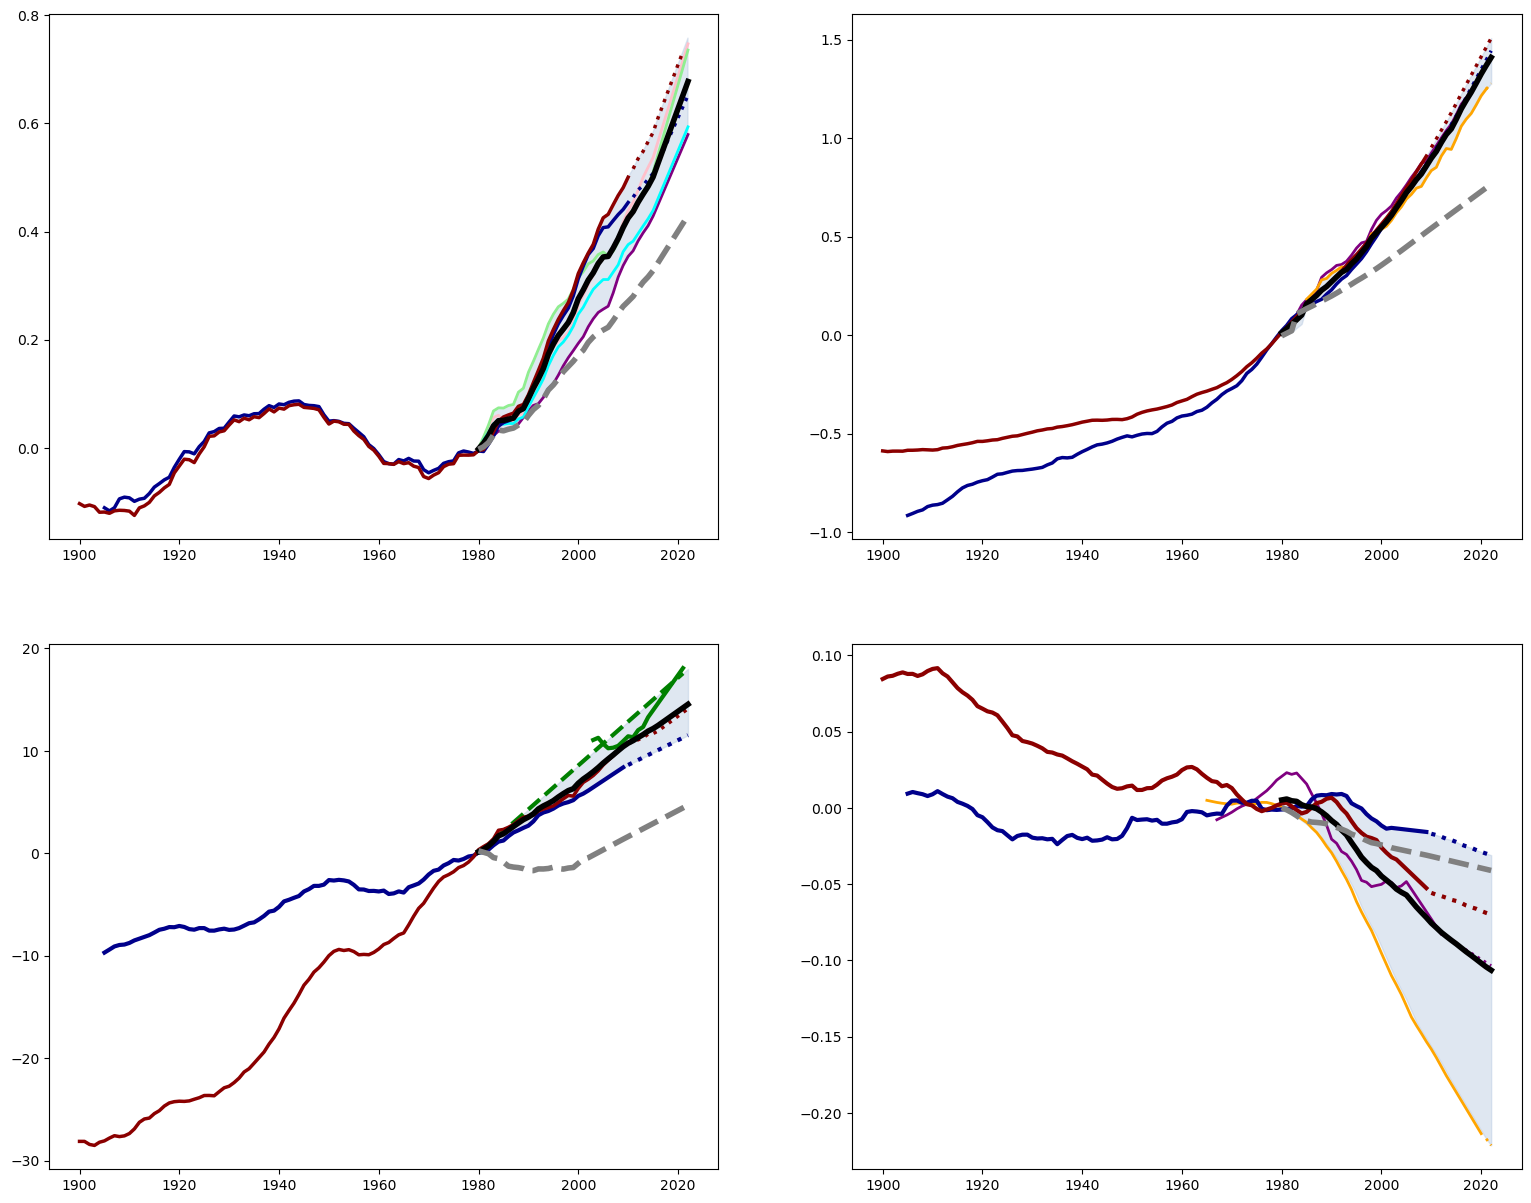

In [13]:
fig

In [13]:
ax[0,0].set_title("Coastal SST ",fontsize=32,pad=16)
ax[0,0].set_ylabel("[°C]",fontsize=25)
ax[0,0].legend(["ESA CCI L4","NOAA-OSSTv2","HadISST","COBEsst","HAMOCC-RIV","_nolegend_","ICON-COAST","_nolegend_", "Coastal mean","_nolegend_", "Open ocean mean"],fontsize=20)
ax[0,1].set_title("Coastal surface H$^{+}$",fontsize=32,pad=16)
ax[0,1].set_ylabel("[M]",fontsize=25)
ax[0,1].legend(["OceanSODA-ETHZ","CMEMS-LSCE","_nolegend_","HAMOCC-RIV","_nolegend_","ICON-COAST","_nolegend_","Coastal mean","_nolegend_","Open ocean mean"],fontsize=20)
ax[1,0].set_title("Coastal NPP",fontsize=32,pad=16)
ax[1,0].set_ylabel("[g C m$^{-2}$ yr$^{-1}$]",fontsize=25)
ax[1,0].legend(["VPGM trend","VGPM-Standard","HAMOCC-RIV","_nolegend_","ICON-COAST","_nolegend_","Coastal mean","_nolegend_","Open ocean mean","_nolegend_"],fontsize=20)
ax[1,1].set_title("Coastal O$_{2}$",fontsize=32,pad=16)
ax[1,1].set_ylabel("[mg O$_{2}$ ℓ$^{-1}$]",fontsize=25)
ax[1,1].legend(["Ito 2022","_nolegend_","Ito et al., 2024","_nolegend_","HAMOCC-RIV","_nolegend_","ICON-COAST","_nolegend_","Coastal mean","_nolegend_","Open ocean mean"],fontsize=20)
fig.tight_layout() 

alphabet=list(string.ascii_lowercase)
count = 0
for axe in ax.reshape(-1):
    axe.tick_params(axis='both', which='major', labelsize=22)

    axe.minorticks_on()
    axe.tick_params('both', length=15, width=2, which='major')
    axe.tick_params('both', length=5, width=1, which='minor')

    title_pos =axe.title.get_position()
    axe.annotate("({})".format(alphabet[count]),
            xy=([title_pos[0]-0.68,title_pos[1]+0.05]), xytext=(0, 0.5), 
            xycoords=('axes fraction', 'axes fraction'),
            textcoords='offset points',size=28)
    count = count + 1
    axe.set_xlim(1900,2022)
    
fig
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)
fig.savefig("figures/Fig2.png",dpi=500,bbox_inches='tight',facecolor="white")

/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/1618545050.py:3: UserWarning: The handle <matplotlib.lines.Line2D object at 0x134a15a60> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax[0,0].legend(["ESA CCI L4","NOAA-OSSTv2","HadISST","COBEsst","HAMOCC-RIV","_nolegend_","ICON-COAST","_nolegend_", "Coastal mean","_nolegend_", "Open ocean mean"],fontsize=20)
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/1618545050.py:3: UserWarning: The handle <matplotlib.lines.Line2D object at 0x134a16250> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax[0,0].legend(["ESA CCI L4","NOAA-OSSTv2","HadISST","COBEsst","HAMOCC-RIV","_nolegend_","ICON-COAST","_nolegend_", "Coastal mean","_nolegend_", "Open ocean mean"],fontsize=20)
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/1618545050.py:3: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x134a16160> has a la

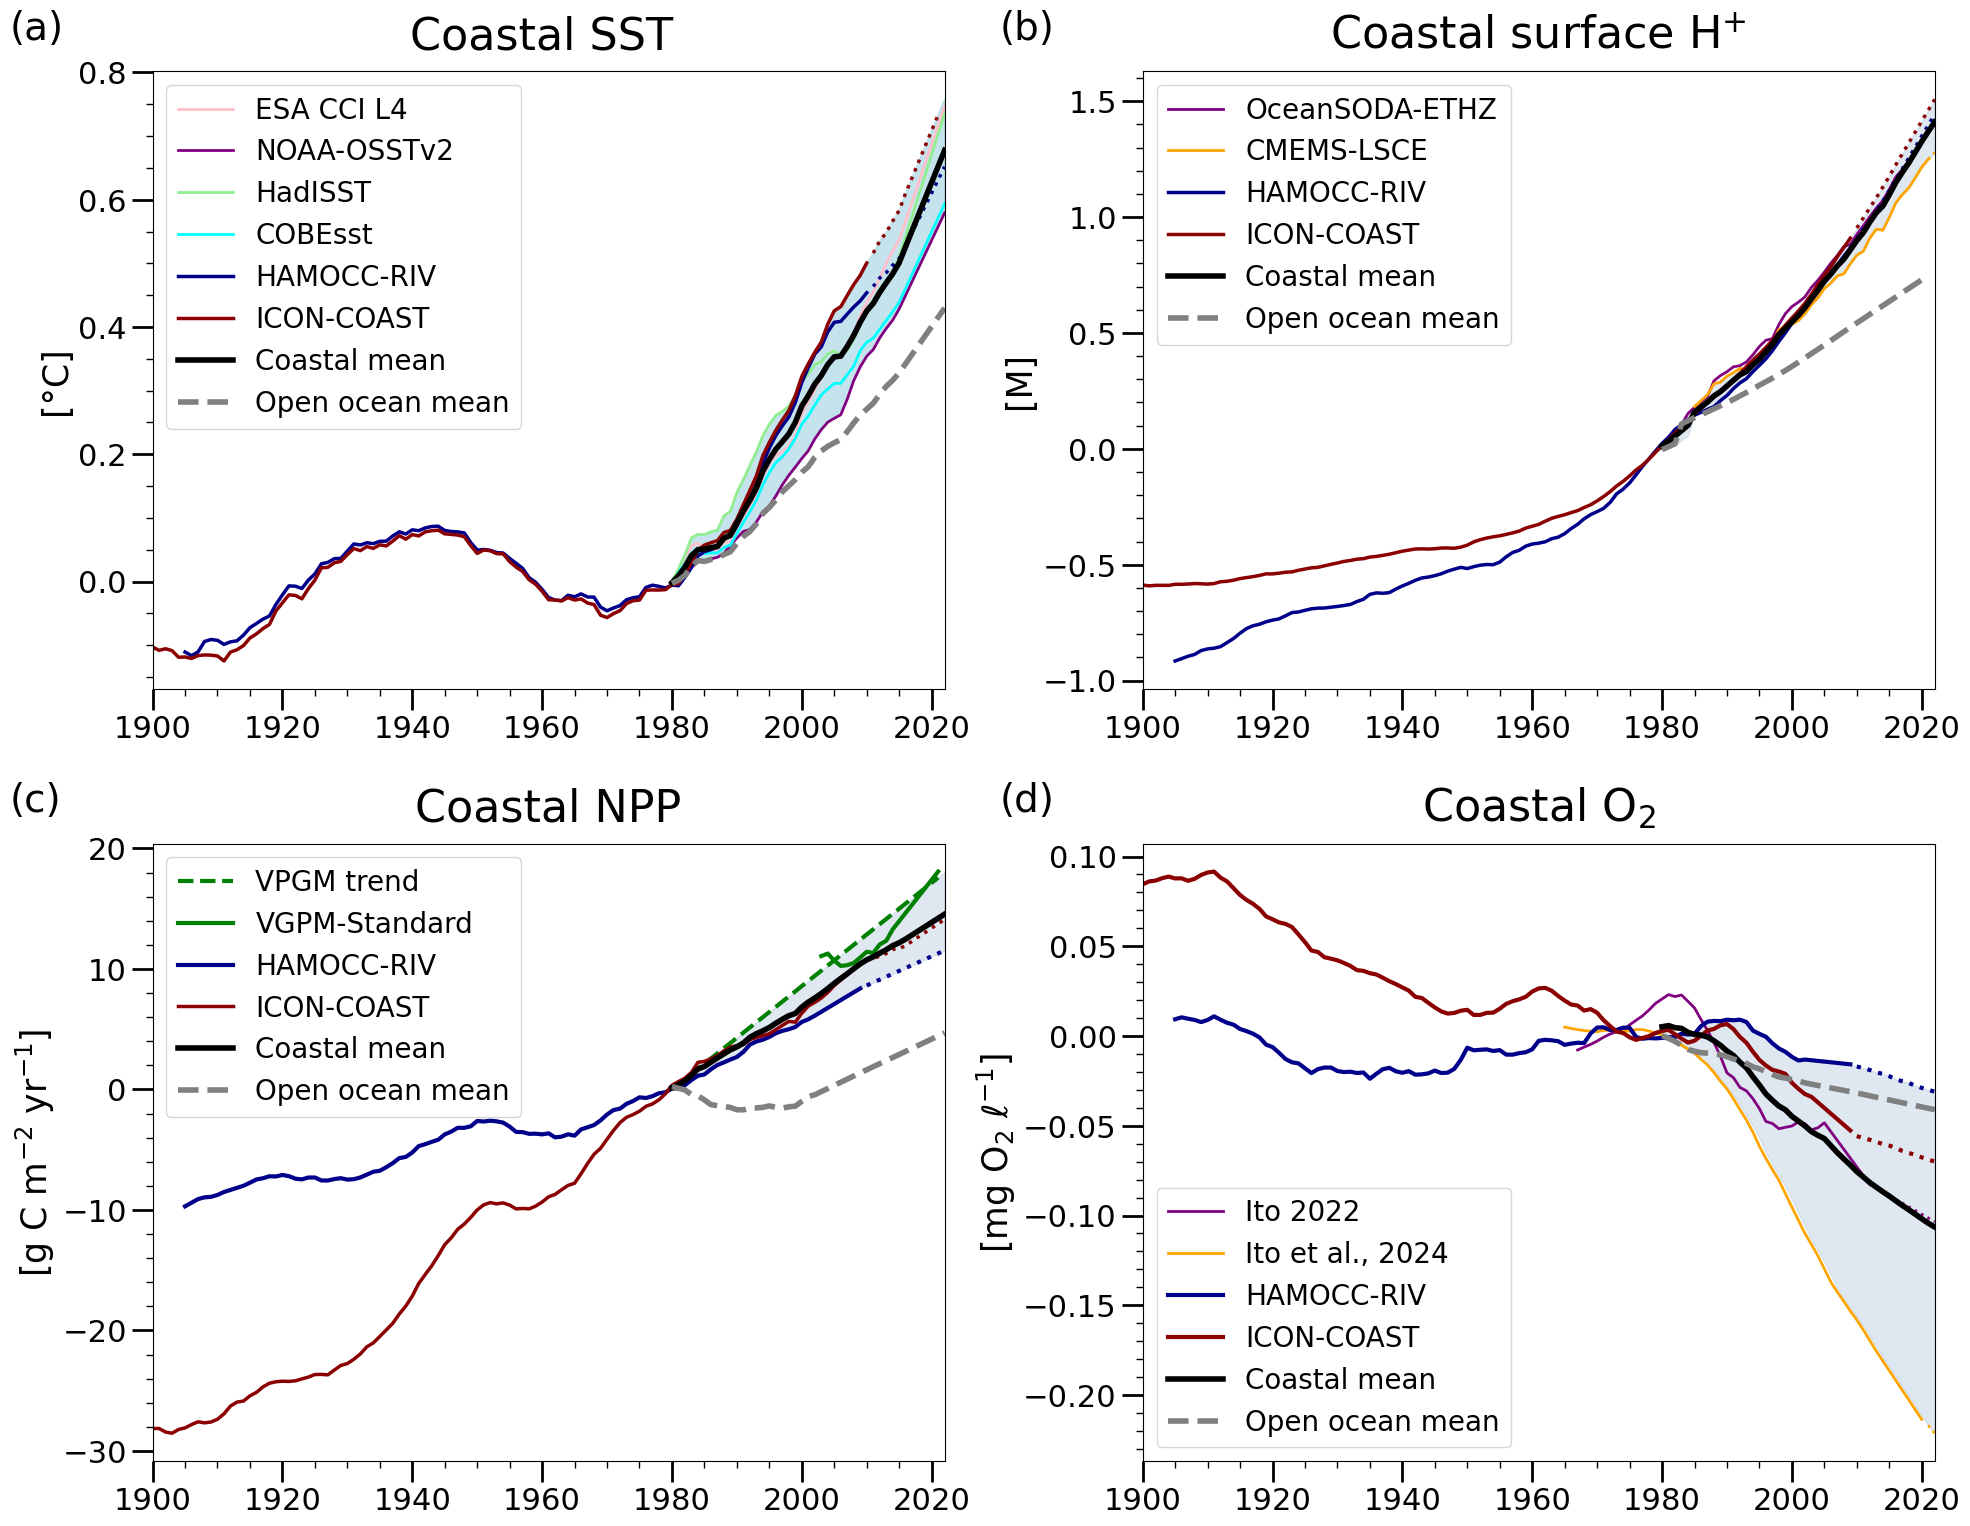

In [14]:
fig

In [15]:
data_npp={"coastal":0.48 / 0.046}
data_npp["global"]=1.29 / 0.96
data_oxygen={"coastal":0.0955/0.032}
data_oxygen["global"]=0.050/0.041

data_npp["coastal"]/data_npp["global"]
0.0955/0.032 /(0.050/0.041)

2.4471875

/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/3250393073.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1519a24f0> has a label of '_' which cannot be automatically added to the legend.
  ax[0].legend(["Open ocean mean","_","_","_","_","Coastal ocean mean","_","_","_","_","River-driven areas"],fontsize=16,loc="lower left")
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/3250393073.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1519a27c0> has a label of '_' which cannot be automatically added to the legend.
  ax[0].legend(["Open ocean mean","_","_","_","_","Coastal ocean mean","_","_","_","_","River-driven areas"],fontsize=16,loc="lower left")
/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/3250393073.py:35: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1519a2970> has a label of '_' which cannot be automatically added to the legend.
  ax[0].legend(["Open ocean mean","_","_","_","

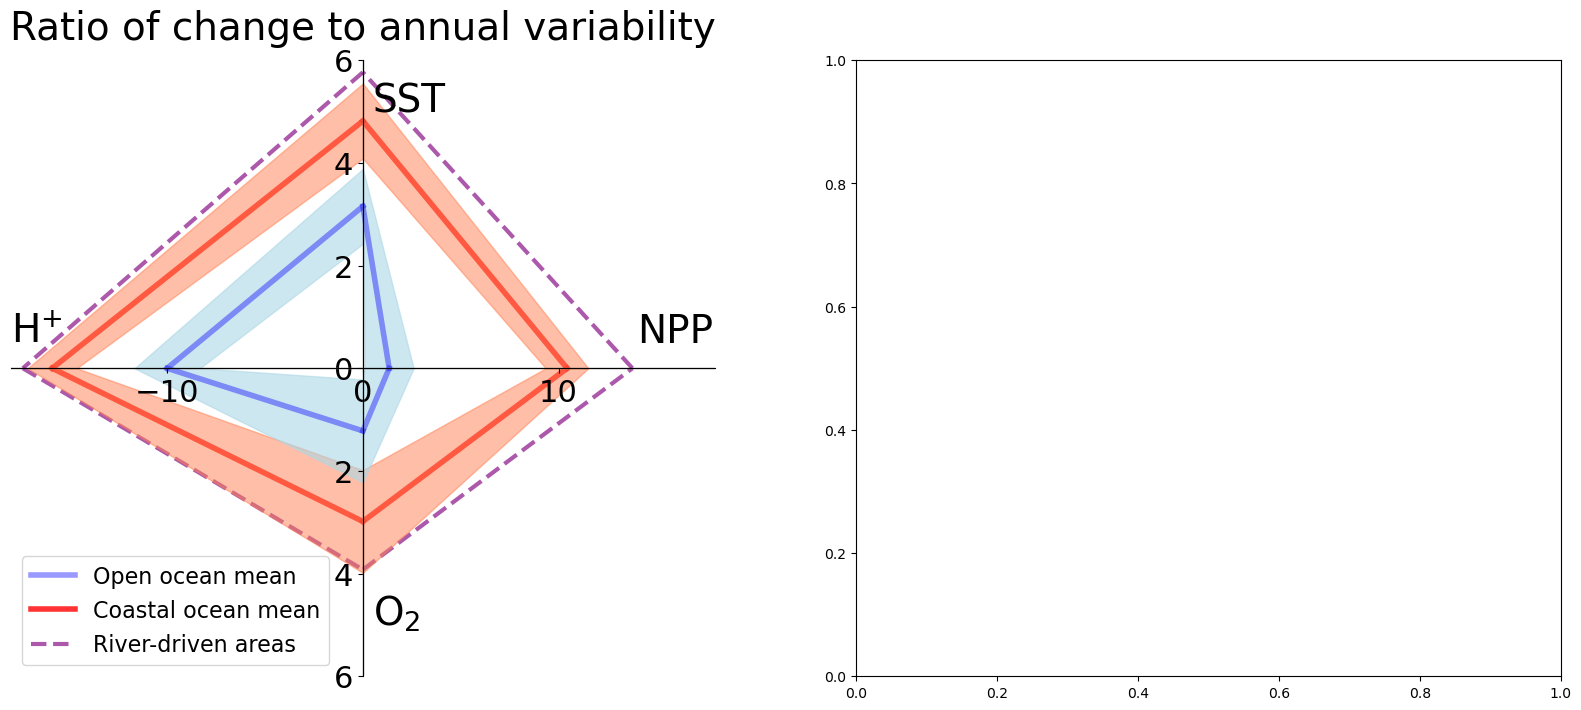

In [16]:
fig, ax =  plt.subplots(1,2,figsize=(20,8))


ax[0].plot([0,data_npp["global"]],[-data_oxygen["global"],0],color="blue",linewidth=4,zorder=2,alpha=0.4)
ax[0].plot([data_npp["global"],0],[0,0.47/0.149],color="blue",linewidth=4,zorder=2,alpha=0.4)
ax[0].plot([0,-0.6/0.06],[0.47/0.149,0],color="blue",linewidth=4,zorder=2,alpha=0.4)
ax[0].plot([-0.6/0.06,0],[0,-data_oxygen["global"]],color="blue",linewidth=4,zorder=2,alpha=0.4)

ax[0].plot([0,data_npp["coastal"]],[-data_oxygen["coastal"],0],color="red",linewidth=4,zorder=1,alpha=0.8)
ax[0].plot([data_npp["coastal"],0],[0,0.66/0.137],color="red",linewidth=4,zorder=1,alpha=0.8)
ax[0].plot([0,-1.27/0.08],[0.66/0.137,0],color="red",linewidth=4,zorder=1,alpha=0.8)
ax[0].plot([-1.27/0.08,0],[0,-data_oxygen["coastal"]],color="red",linewidth=4,zorder=1,alpha=0.8)

ax[0].plot([0,data_npp["coastal"]+0.32*data_npp["coastal"]],[-data_oxygen["coastal"]-0.03/0.032,0],color="purple",linestyle="dashed",linewidth=3,zorder=1,alpha=0.65)
ax[0].plot([data_npp["coastal"]+0.32*data_npp["coastal"],0],[0,(0.66+0.13)/0.137],color="purple",linewidth=3,linestyle="dashed",zorder=1,alpha=0.65)
ax[0].plot([0,-(1.27+0.12)/0.08],[(0.66+0.13)/0.137,0],color="purple",linewidth=3,zorder=1,linestyle="dashed",alpha=0.65)
ax[0].plot([-(1.27+0.12)/0.08,0],[0,-data_oxygen["coastal"]-0.03/0.032],color="purple",linewidth=3,linestyle="dashed",zorder=1,alpha=0.65)

ax[0].set_xlim(-18,18)
ax[0].set_ylim(-6,6)

ax[0].axvline(x=0,linewidth=1, color='grey')
ax[0].axhline(y=0,linewidth=1, color='grey')

ax[0].spines['left'].set_position('center')
ax[0].spines['bottom'].set_position('center')
ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')

ax[0].text(0.5, 5, 'SST', fontsize=28)
ax[0].text(14, 0.5, 'NPP', fontsize=28)
ax[0].text(-18, 0.5, 'H$^{+}$', fontsize=28)
ax[0].text(0.5, -5, 'O$_{2}$', fontsize=28)

ax[0].legend(["Open ocean mean","_","_","_","_","Coastal ocean mean","_","_","_","_","River-driven areas"],fontsize=16,loc="lower left")
ax[0].set_title("Ratio of change to annual variability",fontsize=28,pad=15)

ax[0].fill_between([0,data_npp["coastal"]-0.5/0.46,data_npp["coastal"]+0.5/0.46],[-data_oxygen["coastal"]-1,intermediate_point(-data_oxygen["coastal"]-1,data_npp["coastal"],0.5/0.46,-1),0],[-data_oxygen["coastal"]+1,0,0], color="coral",alpha=0.5,zorder=1)
ax[0].fill_between([0,data_npp["coastal"]-0.5/0.46,data_npp["coastal"]+0.5/0.46],[0.66/0.137 + 0.1/0.137, intermediate_point(0.66/0.137 + 0.1/0.137,data_npp["coastal"],0.5/0.46,-1),0],[0.66/0.137 - 0.1/0.137,0,0], color="coral",alpha=0.5,zorder=1)
ax[0].fill_between([-1.27/0.08-0.1/0.08,-1.27/0.08+0.1/0.08,0],[0, intermediate_point(0.66/0.137+0.1/0.137,-1.27/0.08,-0.1/0.08,-1),0.66/0.137 + 0.1/0.137],[0,0,0.66/0.137 - 0.1/0.137], color="coral",alpha=0.5,zorder=1)
ax[0].fill_between([-1.27/0.08-0.1/0.08,-1.27/0.08+0.1/0.08,0],[0, intermediate_point(-data_oxygen["coastal"]-1,-1.27/0.08,-0.1/0.08,-1),-data_oxygen["coastal"]-1],[0,0,-data_oxygen["coastal"]+1], color="coral",alpha=0.5,zorder=1)


ax[0].fill_between([0,data_npp["global"]-2.5/2,data_npp["global"]+2.5/2],[-data_oxygen["global"]-1,intermediate_point(-data_oxygen["global"]-1,data_npp["global"],2.5/2,-1),0],[-data_oxygen["global"]+1,0,0], color="lightblue",alpha=0.6,zorder=1)
ax[0].fill_between([0,data_npp["global"]-2.5/2,data_npp["global"]+2.5/2],[0.47/0.149 + 0.1/0.137, intermediate_point(0.47/0.149+0.1/0.137,data_npp["global"],2.5/2,-1),0],[0.47/0.149+0.1/0.137,0,0], color="lightblue",alpha=0.6,zorder=1)
ax[0].fill_between([-0.6/0.06-0.1/0.06,-0.6/0.06+0.1/0.06,0],[0, intermediate_point(0.47/0.149+0.1/0.137,0.6/0.06,+0.1/0.06,-1),0.47/0.149 + 0.1/0.137],[0,0,0.47/0.149 - 0.1/0.137], color="lightblue",alpha=0.6,zorder=1)
ax[0].fill_between([-0.6/0.06-0.1/0.06,-0.6/0.06+0.1/0.06,0],[0, intermediate_point(-data_oxygen["global"]-1,-0.6/0.06,-0.1/0.06,-1),-data_oxygen["global"]-1],[0,0,-data_oxygen["global"]+1], color="lightblue",alpha=0.6,zorder=1)


#ax[0].set_xticklabels(["20","10","0","5","10","20"],zorder=0)
ax[0].set_yticklabels(["6","4","2","0","2","4","6"],zorder=0)
ax[0].tick_params(axis='both', which='major', labelsize=22)

fig
fig.savefig("figures/coastal_openocean_rel.png",dpi=500,bbox_inches='tight',facecolor="white")

In [17]:
var_npp_vgpm

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [18]:
fig
fig.savefig("figures/coastal_openocean_rel.png",dpi=500,bbox_inches='tight',facecolor="white")

In [21]:
print("sst trend to natural variability",0.62/0.137)
print("hi trend to natural variability",-1.9/0.08)
print("NPP trend to natural variability",data_npp["coastal"])
print("oxygen trend to natural variability",-data_oxygen["coastal"])

sst trend to natural variability 4.525547445255474
hi trend to natural variability -23.75
NPP trend to natural variability 10.434782608695652
oxygen trend to natural variability -2.984375


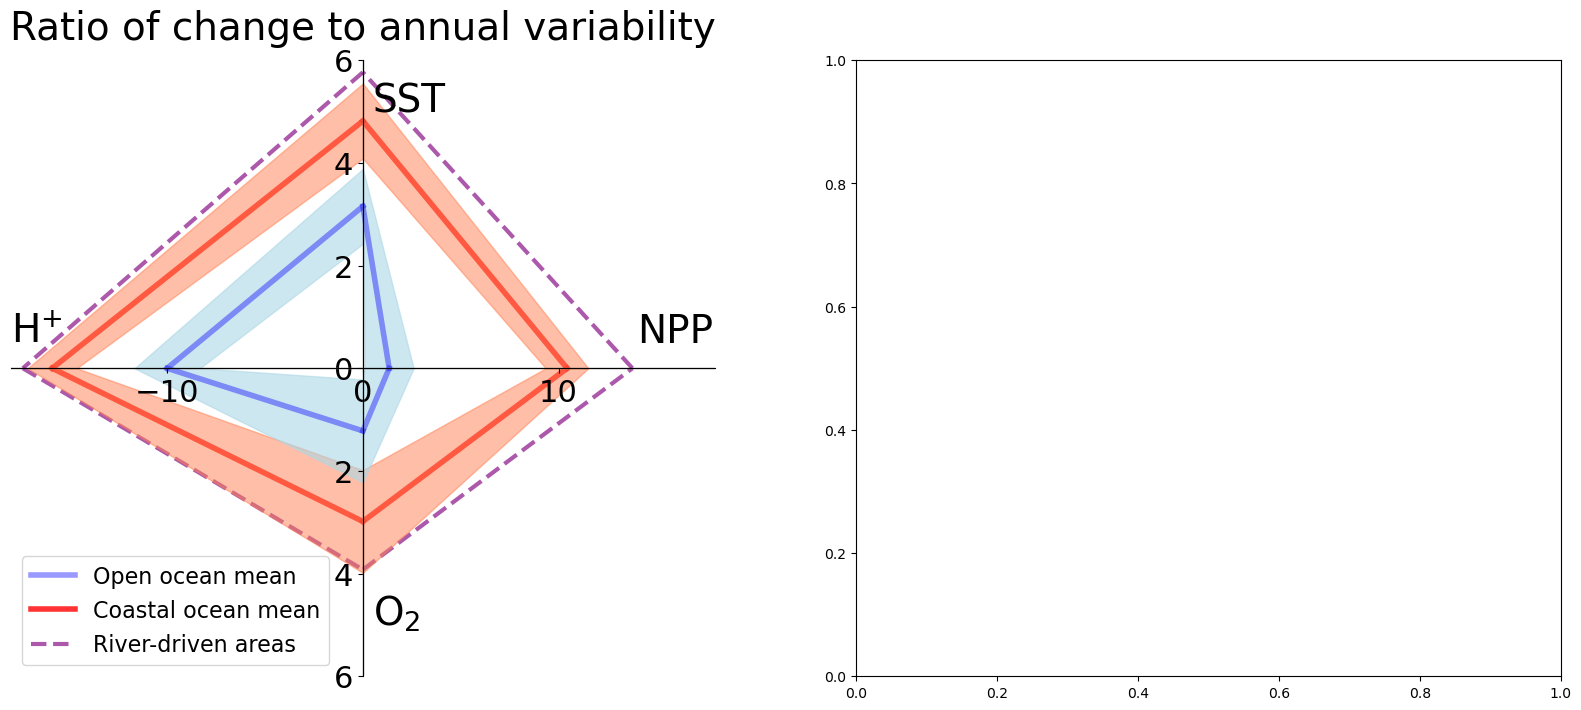

In [22]:
fig

In [23]:
### Define relative effects on drivers
sst_drivers_rel={"base":0,"co2":0,"climate":1,"nutrient":0}
hi_drivers_rel={"base":0,"co2":0.9,"climate":0.09,"nutrient":0.01}
npp_drivers_rel={"base":0,"co2":0,"climate":0.437,"nutrient":0.563}
oxygen_drivers_rel={"base":0,"co2":0,"climate":0.938,"nutrient":-0.07}

sst_drivers_abs=sst_drivers_rel
hi_drivers_abs=hi_drivers_rel
npp_drivers_abs=npp_drivers_rel
oxygen_drivers_abs=oxygen_drivers_rel

sst_drivers_rel={"base":0,"co2":0,"climate":1,"nutrient":0}
hi_drivers_rel={"base":0,"co2":0.9,"climate":0.09,"nutrient":0.01}
npp_drivers_rel={"base":0,"co2":0,"climate":0.461,"nutrient":0.544}
oxygen_drivers_rel={"base":0,"co2":0,"climate":0.938,"nutrient":0.062}

In [24]:
### Define absolute values of driver effects
for key in sst_drivers_rel:
    sst_drivers_abs[key] = sst_drivers_rel[key] * 0.6556
    hi_drivers_abs[key] = hi_drivers_rel[key] * 1.2748
    npp_drivers_abs[key] = npp_drivers_rel[key] * 0.48
    oxygen_drivers_abs[key]= oxygen_drivers_rel[key] * -0.0953

In [25]:
### Information for plotting
drivers=["base","co2","climate","nutrient"]
colors = ["black","lightblue","orange","brown"]
x_loc_drivers={"sst":0.1,"hi":0.6,"npp":1.1,"o2":1.6}
### Define base and temporary bases
base = 0
new_base=0
for i in np.arange(1,len(drivers)):
    ### SST
    ### Define new base and target for every driver
    new_base = new_base+sst_drivers_rel[drivers[i-1]]
    new_target = new_base + sst_drivers_rel[drivers[i]]
    ### Shift X location
    x_loc_new=x_loc_drivers["sst"]+0.1 * i  # slightly move arrows
    ### Plot arrow
    ax[1].annotate("", xytext=(x_loc_new, new_base),
                   xy=(x_loc_new,
                       new_target),
                   arrowprops=dict(arrowstyle="->",
                                   edgecolor=colors[i],
                                   facecolor=colors[i],
                                   lw=6*sst_drivers_rel[drivers[i]],
                                   mutation_scale=40*sst_drivers_rel[drivers[i]]),
                alpha=0)
    ### Write absolute value beside arrow
    if sst_drivers_rel[drivers[i]] > 0.1:
        ax[1].annotate("{} °C".format(round(sst_drivers_abs[drivers[i]],2))
                    ,xytext=(x_loc_new+0.075, new_base+new_target/3),
                    xy=(x_loc_new,
                       new_target),
                    rotation=90,
                    fontsize=18,
                   color=colors[i])

### H+
### Define base and temporary bases
base = 0
new_base=0
for i in np.arange(1,len(drivers)):    
    ### H+
    ### Define new base and target for every driver
    new_base = new_base+hi_drivers_rel[drivers[i-1]]
    new_target = new_base + hi_drivers_rel[drivers[i]]
    print(new_base)
    print(new_target)
    ### Shift X location
    x_loc_new=x_loc_drivers["hi"]+0.1 * i  # slightly move arrows
    ### Plot arrow
    ax[1].annotate("", xytext=(x_loc_new, new_base),
                   xy=(x_loc_new,
                       new_target),
                   arrowprops=dict(arrowstyle="->",
                                   edgecolor=colors[i],
                                   facecolor=colors[i],
                                   lw=8*1*hi_drivers_rel[drivers[i]]/(0.2+hi_drivers_rel[drivers[i]]),
                                   mutation_scale=60*hi_drivers_rel[drivers[i]]/(0.2+hi_drivers_rel[drivers[i]])),                                    
                                   alpha=0)
### Write absolute value beside arrow
    if hi_drivers_rel[drivers[i]] > 0.1:
        ax[1].annotate("{} 10$^-$$^9$M".format(round(hi_drivers_abs[drivers[i]],2))
                    ,xytext=(x_loc_new+0.075, new_base+new_target/3),
                    xy=(x_loc_new,
                       new_target),
                    rotation=90,
                    fontsize=18,
                   color=colors[i])
    
### NPP
### Define base and temporary bases
base = 0
new_base=0
for i in np.arange(1,len(drivers)):    
    ### NPP
    ### Define new base and target for every driver
    new_base = new_base+npp_drivers_rel[drivers[i-1]]
    new_target = new_base + npp_drivers_rel[drivers[i]]
    print(new_base)
    print(new_target)
    ### Shift X location
    x_loc_new=x_loc_drivers["npp"]+0.1 * i  # slightly move arrows
    ### Plot arrow
    ax[1].annotate("", xytext=(x_loc_new, new_base),
                   xy=(x_loc_new,
                       new_target),
                   arrowprops=dict(arrowstyle="->",
                                   edgecolor=colors[i],
                                   facecolor=colors[i],
                                   lw=8*1*npp_drivers_rel[drivers[i]]/(0.2+npp_drivers_rel[drivers[i]]),
                                   mutation_scale=60*npp_drivers_rel[drivers[i]]/(0.2+npp_drivers_rel[drivers[i]])),                                    
                                   alpha=0)
### Write absolute value beside arrow
    if npp_drivers_rel[drivers[i]] > 0.1:
        ax[1].annotate("{} Pg C yr-1".format(round(npp_drivers_abs[drivers[i]],2))
                    ,xytext=(x_loc_new+0.075, new_base+new_target/9),
                    xy=(x_loc_new,
                       new_target),
                    rotation=90,
                    fontsize=18,
                   color=colors[i])
    
### O2
### Define base and temporary bases
base = 0
new_base=0
for i in np.arange(1,len(drivers)):    
    ### O2
    ### Define new base and target for every driver
    new_base = new_base+oxygen_drivers_rel[drivers[i-1]]
    new_target = new_base + oxygen_drivers_rel[drivers[i]]
    ### Shift X location
    x_loc_new=x_loc_drivers["o2"]+0.1 * i  # slightly move arrows
    ### Plot arrow
    ax[1].annotate("", xytext=(x_loc_new, new_base),
                   xy=(x_loc_new,
                       new_target),
                   arrowprops=dict(arrowstyle="->",
                                   edgecolor=colors[i],
                                   facecolor=colors[i],
                                   lw=8*1*abs(oxygen_drivers_rel[drivers[i]])/(0.2+abs(oxygen_drivers_rel[drivers[i]])),
                                   mutation_scale=60*abs(oxygen_drivers_rel[drivers[i]])/(0.2+abs(oxygen_drivers_rel[drivers[i]]))),                                    
                                   alpha=0)
### Write absolute value beside arrow
    if oxygen_drivers_rel[drivers[i]] > 0.1:
        ax[1].annotate("{} mg O$_2$ L$^-$$^1$".format(round(oxygen_drivers_abs[drivers[i]],2))
                    ,xytext=(x_loc_new+0.075, new_base+new_target/3),
                    xy=(x_loc_new,
                       new_target),
                    rotation=90,
                    fontsize=18,
                   color=colors[i])
    
#### Plot axis & legend
ax[1].set_xlim(0,2.5)
ax[1].set_ylim(0,1.1)
ax[1].set_xticks(np.arange(0.3,2.3,0.5))
ax[1].set_xticklabels(["SST","H$^{+}$","NPP","O$_{2}$"],fontsize=28)
ax[1].set_yticklabels([0,"","","","",1],fontsize=24)
ax[1].set_title("Driver contribution to total change",fontsize=28)

### Axes with arrows
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

###Legend
ax[1].text(2.0, 0.6, "Change caused by:", fontsize=19, color = "black")
ax[1].text(2.1, 0.5, "Ant. CO$_{2}$", fontsize=19, color = colors[1])
ax[1].text(2.1, 0.45, "Climate", fontsize=19, color = colors[2])
ax[1].text(2.1, 0.4, "Ant. Nutrients", fontsize=19, color = colors[3])

alphabet=list(string.ascii_lowercase)
count = 0
for axe in ax.reshape(-1):
    axe.tick_params(axis='both', which='major', labelsize=22)

    axe.minorticks_on()
    axe.tick_params('both', length=15, width=2, which='major')
    axe.tick_params('both', length=5, width=1, which='minor')

    title_pos =axe.title.get_position()
    axe.annotate("({})".format(alphabet[count]),
            xy=([title_pos[0]-0.68,title_pos[1]+0.05]), xytext=(0, 0.5), 
            xycoords=('axes fraction', 'axes fraction'),
            textcoords='offset points',size=28)
    count = count + 1

fig.savefig("figures/Fig3.png",dpi=500,bbox_inches='tight',facecolor="white")

0
0.9
0.9
0.99
0.99
1.0
0
0
0
0.461
0.461
1.0050000000000001


/var/folders/0y/spqmc12x7jl4vpd6l453_34c0000gp/T/ipykernel_30116/3040884372.py:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([0,"","","","",1],fontsize=24)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/matplotlib/patches.py:3391: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


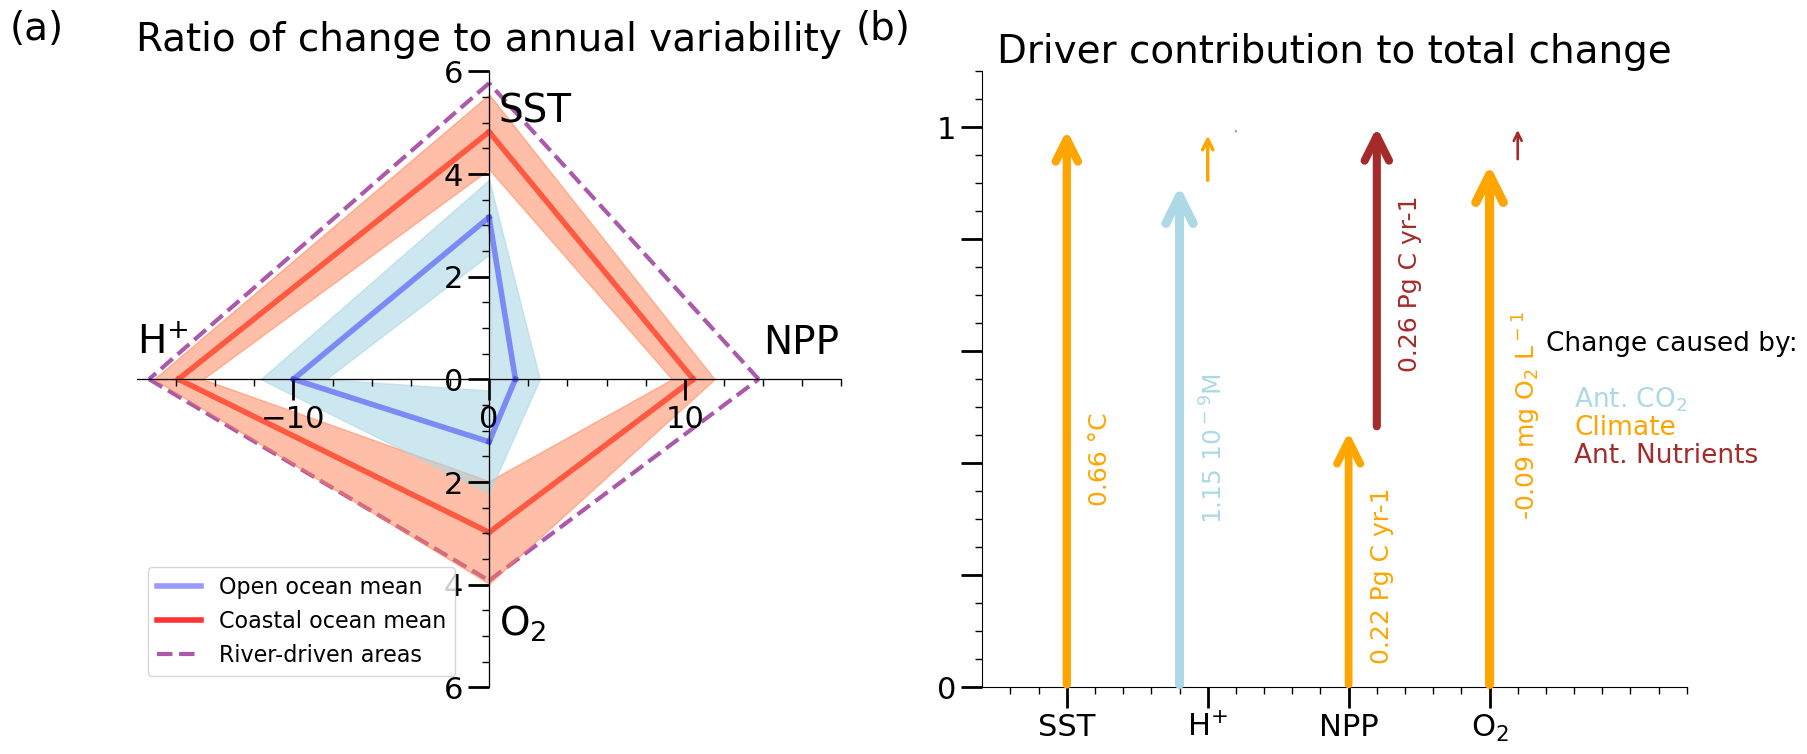

In [26]:
fig

In [61]:
fig.savefig("figures/coastal_openocean_rel.png",dpi=500,bbox_inches='tight',facecolor="white")